In [1]:
#last update: Oct 28 2024
#this file read in the selected sampling data from sampler
#and output the txt file for median data for given sampling trails
# this is the analyzer file for sinesubtract method to filter out the anthopengenic noise
# so far this unit still have some potential problem

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import sys
import os
import inspect
from datetime import datetime, timezone, timedelta
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
#sys.path.append(os.environ['BEACON_INSTALL_DIR'])
sys.path.append('home/youwei/project_beacon/2024_10')
#from beacon_data_reader import Reader 
#from beaconroot.examples.beacon_data_reader import Reader 
from sine_subtract import SineSubtract
from Reader_class import Reader 

file_num = 0
channel = 4

In [2]:
#**********************************************************************************************
#class defination block
import ROOT

class Event:
    def __init__(self, run, entry, channel, readout_time, t, waveform):
        self.run = run
        self.entry = entry
        self.channel = channel
        self.readout_time = readout_time
        self.waveform = waveform
        self.t=t
        self.datetime = datetime.fromtimestamp(self.readout_time)
        
    def set_fft(self):
        # Compute the FFT of the waveform
        waveform_fft = np.fft.fft(self.waveform)
        
        # Compute the corresponding frequency bins
        dt = (self.t[1] - self.t[0])  # Time step between consecutive time points
        freqs = np.fft.fftfreq(len(self.waveform), dt)
        
        # Only consider the positive frequencies and the corresponding FFT values
        self.freqs = freqs[:len(freqs) // 2]
        self.fft = np.abs(waveform_fft[:len(waveform_fft) // 2])

        # Create a mask to keep only frequencies in the range [0.020, 0.12]
        valid_indices = (self.freqs >= 0.020) & (self.freqs <= 0.12)
        #print(valid_indices)
        #print(self.freqs)
    
        # Store the filtered frequencies and FFT magnitudes
        self.freqs = self.freqs[valid_indices]
        self.fft = self.fft[valid_indices]
        
        # Find the index of the largest amplitude
        max_idx = np.argmax(self.fft)
        
        # Get the largest amplitude and its corresponding frequency
        max_amplitude = self.fft[max_idx]
        max_frequency = self.freqs[max_idx]
        
        # Calculate the median amplitude
        median_amplitude = np.median(self.fft)
        
        return max_amplitude, max_frequency, median_amplitude

    #haven't correct fft_v to fft yet
    def analyze_fft_histogram(self):
    
        # Define the histogram bins (brackets of size 0.1)
        bin_edges = np.arange(0.031, np.max(self.freqs_v) + 0.001, 0.001)
        
        # Use `np.digitize` to find the bin index for each frequency value
        bin_indices = np.digitize(self.freqs_v, bin_edges) - 1  # Adjust to 0-based indexing
    
        # Initialize arrays to store the sum of FFT values in each bracket
        fft_sums = np.zeros(len(bin_edges) - 1)
    
        # Accumulate the FFT magnitudes into the corresponding bins
        for i, fft_value in enumerate(self.fft_v):
            fft_sums[bin_indices[i]] += fft_value
    
        # Compute the values from the brackets:
        # 1. Largest amplitude and its corresponding frequency bracket
        max_idx = np.argmax(fft_sums)
        max_amplitude = fft_sums[max_idx]
        max_frequency_bracket = (bin_edges[max_idx], bin_edges[max_idx + 1])
    
        # 2. Median amplitude across all brackets
        median_amplitude = np.median(fft_sums)
    
        return max_amplitude, max_frequency_bracket, median_amplitude


    def sine_subtraction(self, plot_test=True, min_freq=0.02, max_freq=0.12, min_power_ratio=0.1,max_failed_iterations=5):
        # Filter from 0 to 250 MHz
        max_amplitude, max_frequency, median_amplitude=self.set_fft()
        verbose=False
        if (max_frequency <0.064) & (max_frequency>0.063):
            print("exception")
            verbose=True
            plot_test=True
        else:
            verbose=False
            plot_test=True
        CWsub_broad = SineSubtract(min_freq, max_freq, min_power_ratio,max_failed_iterations, verbose)
        if plot_test:
            event=Event(self.run, self.entry, self.channel, self.readout_time, self.t, self.waveform)
            event.set_V_rms()
            print(event.V_rms)
        nfit, waveform = CWsub_broad.CWFilter(self.t, self.waveform) # sine subraction

        self.waveform=waveform
        self.set_V_rms()
        print(self.V_rms)
        #if plot_test and (1-self.V_rms/event.V_rms)<0.05:
        max_frequency=0
        if plot_test:
            print("warning, the V_rms change is lower than 5%")
            print("nfit found:", nfit)
            # Ensure FFTs are calculated for self and event
            max_amplitude, max_frequency, median_amplitude=self.set_fft()  
            event.set_fft()  # Make sure to call it here if needed.
    
            # Plot both self.fft and event.fft on the same plot
            plt.figure(figsize=(10, 6))
            plt.plot(self.freqs, self.fft, label='FFT after sinesubtraction')
            plt.plot(event.freqs, event.fft, label='FFT before sinesubtraction', linestyle='--')
            
            plt.title(f"Run {self.run}, Event {self.entry}, Channel {self.channel} - FFT Comparison_with min_power_ratio{min_power_ratio}")
            plt.xlabel("Frequency (GHz)")
            plt.ylabel("Amplitude")
            plt.legend()
            plt.tight_layout()
            plt.show()
    
        return nfit, waveform,max_frequency
    
    def plot_fft(self):
        plt.subplot(2, 1, 2)
        plt.plot(self.freqs, self.fft)
        plt.title(f"Run {self.run}, Event {self.entry}, Channel {self.channel} - Frequency Domain (FFT)")
        plt.ylabel("Amplitude")
        plt.xlabel("Frequency (GHz)")
        plt.tight_layout()
        plt.show()

    def plot_wf(self):
        plt.subplot(2, 1, 2)
        plt.plot(self.t, self.waveform)
        plt.title(f"Run {self.run}, Event {self.entry}, Channel {self.channel} - Time Domain")
        plt.ylabel("Amplitude")
        plt.xlabel("time")
        plt.tight_layout()
        plt.show()
        
    def plot_amplitude(self):
        # Compute the amplitude of the waveform (absolute value to get positive values only)
        #amplitudes = np.abs(self.waveform)
        amplitudes = self.waveform
        
        # Define the bin edges with a step size of 1
        bin_edges = np.arange(np.min(amplitudes) - 1, np.max(amplitudes) + 1, 1)

        # Compute the histogram (count of amplitudes in each bin)
        counts, edges = np.histogram(amplitudes, bins=bin_edges)

        # Print the total counts
        total_count = np.sum(counts)
        print(f"Total Counts: {total_count}")

        # Plot the amplitude histogram
        plt.figure(figsize=(8, 5))
        plt.bar(edges[:-1], counts, width=1, align='edge', color='steelblue', edgecolor='black')

        # Add titles and labels
        plt.title(f"Amplitude Distribution - Run {self.run}, Event {self.entry}, Channel {self.channel}")
        plt.xlabel("Amplitude")
        plt.ylabel("Count")

        # Display the plot
        plt.show()

    def cap_amplitude_value(self, cap_value):
        # Calculate and print the initial V_rms using set_V_rms
        initial_V_rms = self.set_V_rms()
        print(f"Initial V_rms: {initial_V_rms}")

        # Compute the amplitude of the waveform (absolute value)
        amplitudes = np.abs(self.waveform)

        # Cap any amplitude that exceeds the cap_value
        capped_amplitudes = np.where(amplitudes > cap_value, self.mean, amplitudes)

        # Update the waveform with the capped values while preserving the original sign
        self.waveform = np.sign(self.waveform) * capped_amplitudes

        # Calculate and print the updated V_rms using set_V_rms
        updated_V_rms = self.set_V_rms()
        print(f"Updated V_rms: {updated_V_rms}")

        print(f"Applied cap of {cap_value} to waveform amplitudes.")



    def cap_amplitude_proportion(self, cap_portion):
        """
        Cap a proportion of the largest amplitude values to the median amplitude.
    
        Parameters:
        - cap_portion (float): A value between 0 and 1, indicating the proportion 
                               of highest amplitudes to cap to the median.
        """
        # Ensure cap_portion is valid
        if not (0 <= cap_portion <= 1):
            raise ValueError("cap_portion must be between 0 and 1.")
    
        # Compute the absolute amplitudes of the waveform
        amplitudes = np.abs(self.waveform)
    
        # Calculate the median amplitude
        median_value = np.median(amplitudes)
    
        # Sort amplitudes in descending order to find the threshold value
        sorted_amplitudes = np.sort(amplitudes)[::-1]  # Descending order
    
        # Compute the threshold index, ensuring it is within bounds
        threshold_index = min(int(len(sorted_amplitudes) * cap_portion), len(sorted_amplitudes) - 1)
        threshold_value = sorted_amplitudes[threshold_index]
    
        # Cap the values that exceed the threshold to the median value
        capped_amplitudes = np.where(amplitudes > threshold_value, median_value, amplitudes)
    
        # Update the waveform with the capped values while preserving the original sign
        self.waveform = np.sign(self.waveform) * capped_amplitudes

        # Calculate and print the updated V_rms using set_V_rms
        updated_V_rms = self.set_V_rms()
        
        print(f"Capped the top {cap_portion * 100:.2f}% of amplitudes to the median value.")

    
    def set_V_rms(self, vrms=None):
        if vrms is None:
            # Calculate V_rms from waveform
            waveform = self.waveform
            self.mean = np.mean(waveform)
            
            # Calculate the squared differences from the mean
            squared_diffs = (waveform - self.mean) ** 2
            
            # Calculate the variance (mean of squared differences)
            variance = np.mean(squared_diffs)
            
            # Calculate the standard deviation (square root of variance)
            self.V_rms = np.sqrt(variance)
        else:
            # Set V_rms directly
            self.V_rms = vrms

        return self.V_rms


def find_median_index(Event_per_point_array):
    # Extract the Vrms values from the events
    vrms_array = [event.set_V_rms() for event in Event_per_point_array]
    
    # Get the sorted indices of the vrms_array
    sorted_indices = np.argsort(vrms_array)
    
    # Find the index of the median value
    median_index = sorted_indices[len(vrms_array) // 2]
    
    # Bootstrap resampling to compute error bars
    n_bootstrap = 1000
    bootstrap_medians = np.array([
        np.median(np.random.choice(vrms_array, size=len(vrms_array), replace=True))
        for _ in range(n_bootstrap)
    ])

    # Calculate 1-sigma (68% confidence interval) error bars
    lower_bound = np.percentile(bootstrap_medians, 16)
    upper_bound = np.percentile(bootstrap_medians, 84)

    # Compute the error bar
    vrms_median = vrms_array[median_index]
    error_bar = (vrms_median - lower_bound, upper_bound - vrms_median)

    return median_index, error_bar
    
def find_median_with_error(Event_per_point_array):
    # Extract the Vrms values from the events
    vrms_array = [event.set_V_rms() for event in Event_per_point_array]
    
    # Calculate the median
    vrms_median = np.median(vrms_array)
    
    # Number of bootstrap samples
    n_bootstrap = 1000
    
    # Array to hold bootstrap medians
    bootstrap_medians = np.zeros(n_bootstrap)
    
    # Bootstrap resampling
    for i in range(n_bootstrap):
        # Resample with replacement
        sample = np.random.choice(vrms_array, size=len(vrms_array), replace=True)
        # Compute the median of the resampled data
        bootstrap_medians[i] = np.median(sample)
    
    # Calculate the 1 sigma (68% confidence interval) error bars
    lower_bound = np.percentile(bootstrap_medians, 16)
    upper_bound = np.percentile(bootstrap_medians, 84)
    vrms_median_20 = np.percentile(bootstrap_medians, 20)
    # Calculate the error bar
    error_bar = (vrms_median - lower_bound, upper_bound - vrms_median)

    t=(Event_per_point_array[len(Event_per_point_array)//2]).readout_time
#t? use middle value?
# how to find the midian error
    #std(median)=1.2533*std(mean)
    return vrms_median, vrms_median_20, t, error_bar


In [3]:

#*********************************************************************************************
#generation data block for file name
#generate an array for the date we what to collect data for:
# Generate an array of filename
#days_apart=15
#start_date = datetime(2024, 2, 14, 0, 0, 1)
#end_date = datetime(2024, 5, 23, 0, 0, 1)
days_apart=1
start_date = datetime(2023, 11, 30, 0, 0, 1)
end_date = datetime(2023, 12, 8, 0, 0, 1)
data_days_arr=[]
test_date=start_date
output_filepath=[]
sample_directory = "sampling/"
while test_date<end_date:
    data_days_arr.append(test_date)
    date_str = test_date.strftime("%Y-%m-%d")
    sample_filename="sampling_at_"+date_str
    output_filepath.append(os.path.join(sample_directory, sample_filename))
    test_date = test_date + timedelta(days=days_apart)


print(output_filepath)

['sampling/sampling_at_2023-11-30', 'sampling/sampling_at_2023-12-01', 'sampling/sampling_at_2023-12-02', 'sampling/sampling_at_2023-12-03', 'sampling/sampling_at_2023-12-04', 'sampling/sampling_at_2023-12-05', 'sampling/sampling_at_2023-12-06', 'sampling/sampling_at_2023-12-07']


In [4]:

##******************************************************************************************
#input block to input the txt into arrays of the size of each data point/data range
# Initialize empty lists to store the data
run_array = []
readout_time_array = []
entry_array = []

# Open the file and read the data
with open(output_filepath[file_num], "r") as file:
    current_array = None  # This will keep track of which array we are currently reading into
    
    for line in file:
        # Remove any leading/trailing whitespace
        line = line.strip()

        # Check if the line indicates the start of a new array
        if line.startswith("Run Array:"):
            current_array = "run"
        elif line.startswith("Readout Time Array (timestamps):"):
            current_array = "readout_time"
        elif line.startswith("Entry Array:"):
            current_array = "entry"
        elif line:  # If the line is not empty, it contains data
            # Depending on which array we're reading, process the line
            if current_array == "run":
                run_array = [int(x.strip()) for x in line.split(",") if x.strip()]
            elif current_array == "readout_time":
                readout_time_array = [float(x.strip()) for x in line.split(",") if x.strip()]
            elif current_array == "entry":
                entry_array = [int(x.strip()) for x in line.split(",") if x.strip()]
                break

# Print the lists to verify the data
print("Run Array:", run_array[:10])
print("Readout Time Array:", readout_time_array[:10])
print("Entry Array:", entry_array[:10])


Run Array: [505, 505, 505, 505, 505, 505, 505, 505, 505, 505]
Readout Time Array: [1701323968.0, 1701324016.0, 1701324100.0, 1701323974.0, 1701324052.0, 1701323948.0, 1701323882.0, 1701323993.0, 1701323973.0, 1701324042.0]
Entry Array: [40896, 41086, 41411, 40913, 41229, 40820, 40553, 40996, 40909, 41192]


In [5]:

#******************************************************************************************
#Data analysis code block start here
datapath = "/project/avieregg/beacon-flower8/root/"

# change this where ever you store data runs
events = []

break_time = 600  #time between every data points


# Loop over each run and entry
for i in range(len(run_array)):
    # Initialize the reader for each run
    reader = Reader(datapath, run_array[i])
    
    # Set the specific entry for the current run
    reader.setEntry(entry_array[i])
    
    # Get the time array (assuming it's the same for all channels)
    t = reader.t()
    
    # Read the waveform for the current channel
    waveform = reader.wf(channel)
    
    # Create an Event object and add it to the events list
    event = Event(run_array[i], entry_array[i], channel, readout_time_array[i], t, waveform)
    event.set_V_rms()
    events.append(event)

    

events_slice=[]
samples=[]
for event_id in range(len(events)):
    end=False
    if event_id == len(events)-1:
        end=True
    else:
        t_diff = events[event_id+1].readout_time - events[event_id].readout_time
        
    if t_diff < break_time and not (end):
        samples.append(events[event_id])
    elif end :
        samples.append(events[event_id])
        events_slice.append(samples)
    else:
        events_slice.append(samples)
        samples=[]


medium_events=[]
error_bar_arr=[]
for e_slice in events_slice:
    index,error_bar = find_median_index(e_slice)
    medium_events.append(e_slice[index])
    error_bar_arr.append(error_bar)

vrms_median_arr=[]
vrms_median_arr_capped=[]
t_array=[]

print(medium_events[]


exception
7.701412358738879
3.922468213861029
warning, the V_rms change is lower than 5%
nfit found: 12


/home/youwei/miniforge3/envs/root_env/lib/python3.12/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/youwei/miniforge3/envs/root_env/lib/python3.12/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


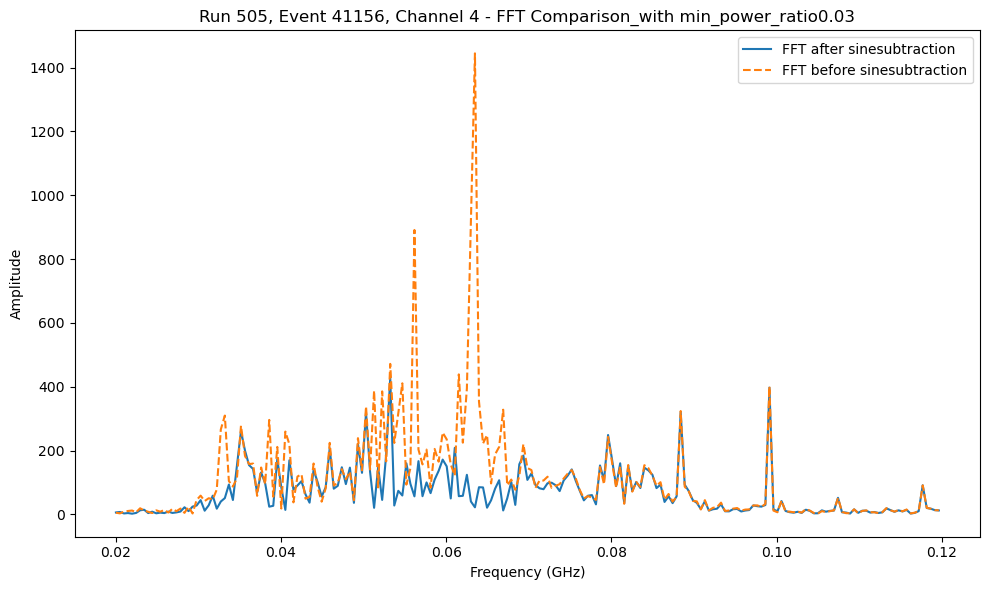

exception
7.60394657460989
4.967947671634817
warning, the V_rms change is lower than 5%
nfit found: 1


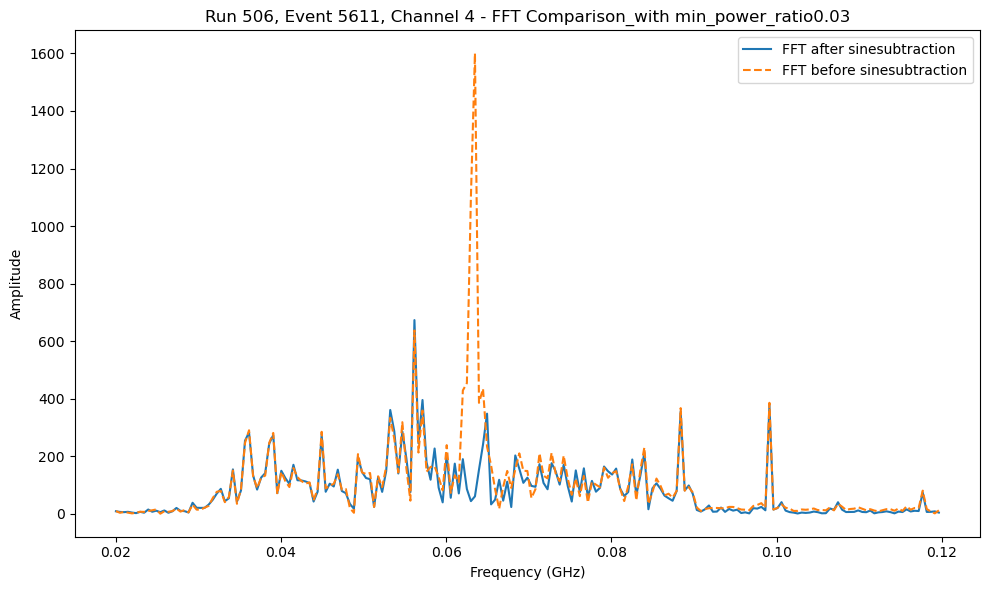

4.073051482926328
3.826899782218514
warning, the V_rms change is lower than 5%
nfit found: 2


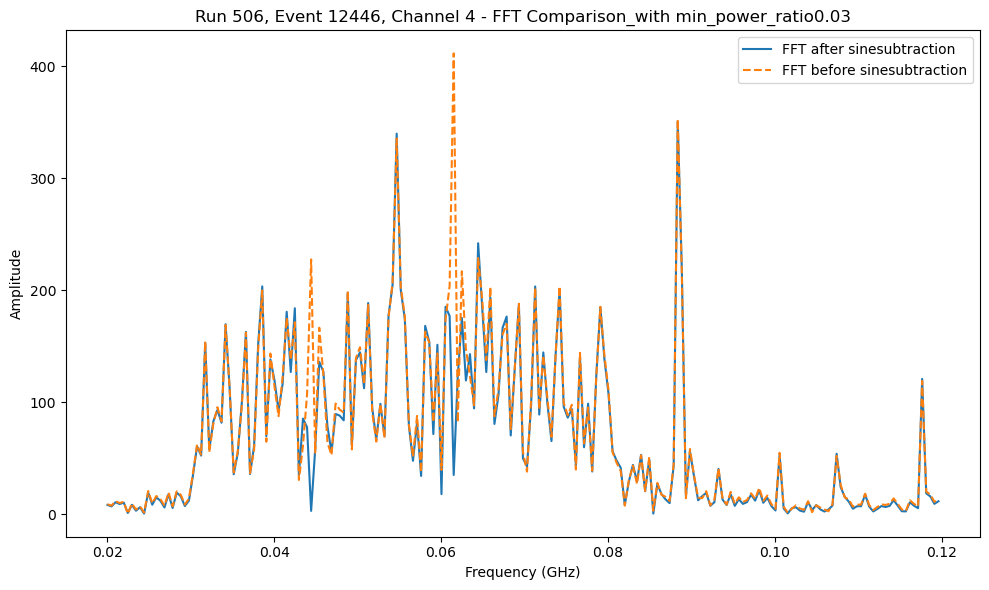

4.073902267789447
3.4974112375362463
warning, the V_rms change is lower than 5%
nfit found: 7


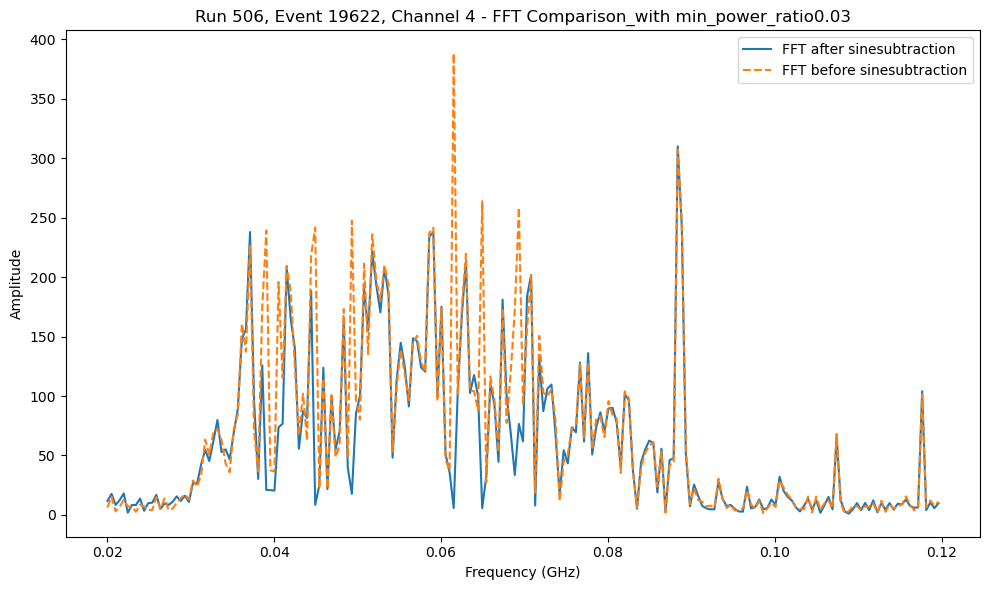

4.101138370928248
4.002966721157829
warning, the V_rms change is lower than 5%
nfit found: 1


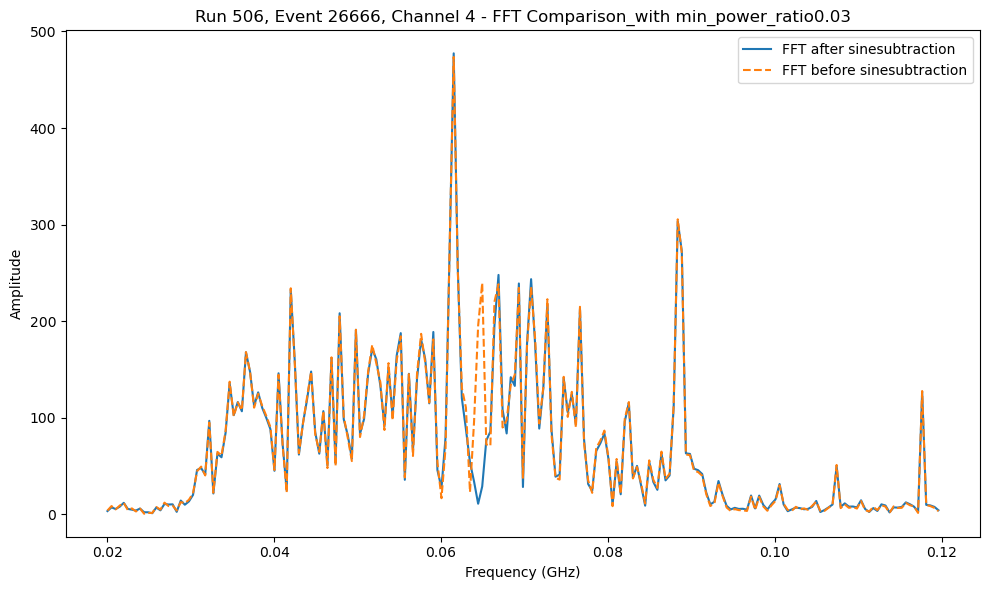

4.129092411691352
3.8634404503642745
warning, the V_rms change is lower than 5%
nfit found: 2


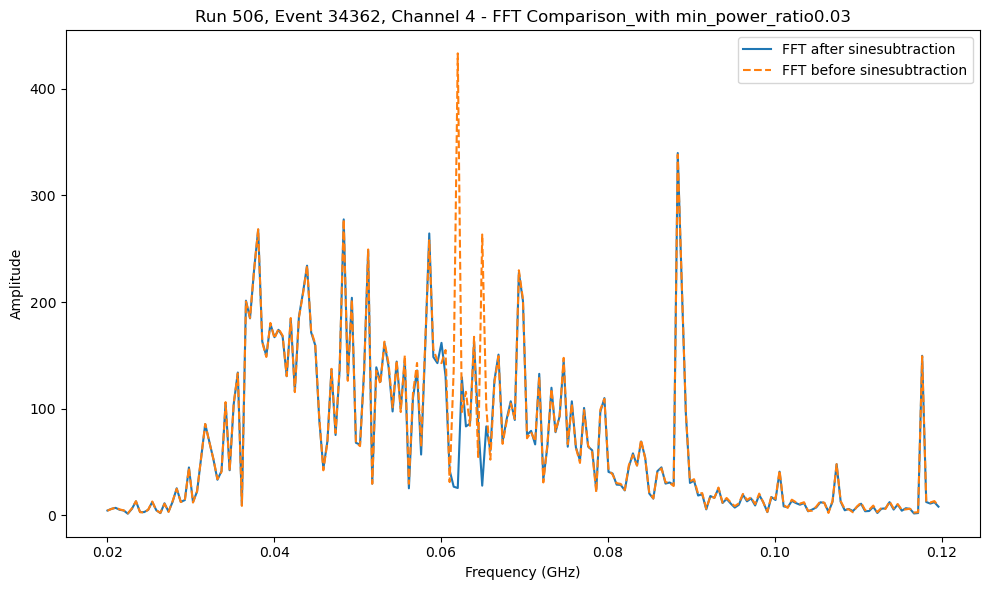

4.1046472774723215
4.029940486460977
warning, the V_rms change is lower than 5%
nfit found: 1


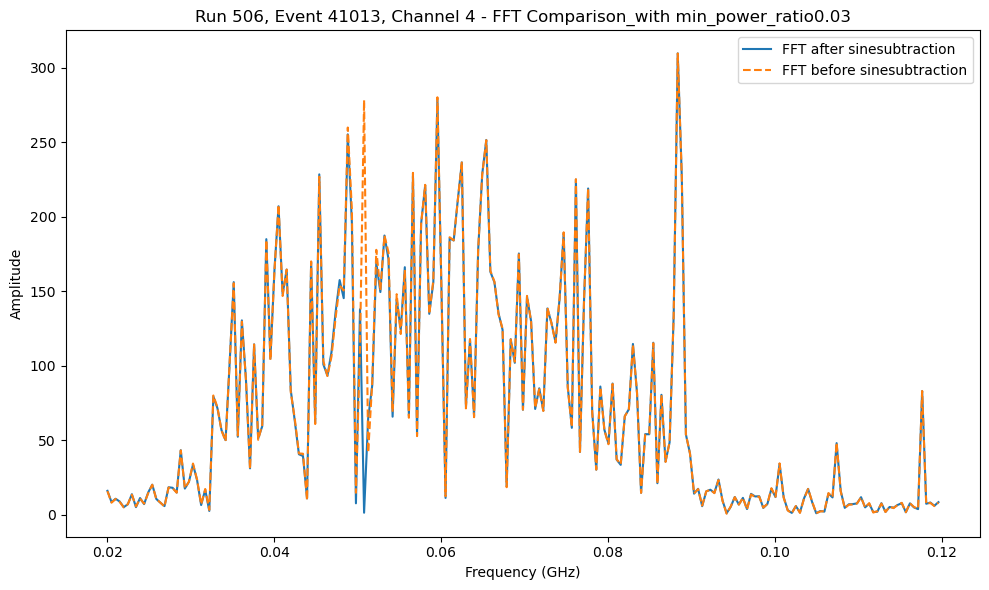

4.1387064393613295
3.939143130894117
warning, the V_rms change is lower than 5%
nfit found: 2


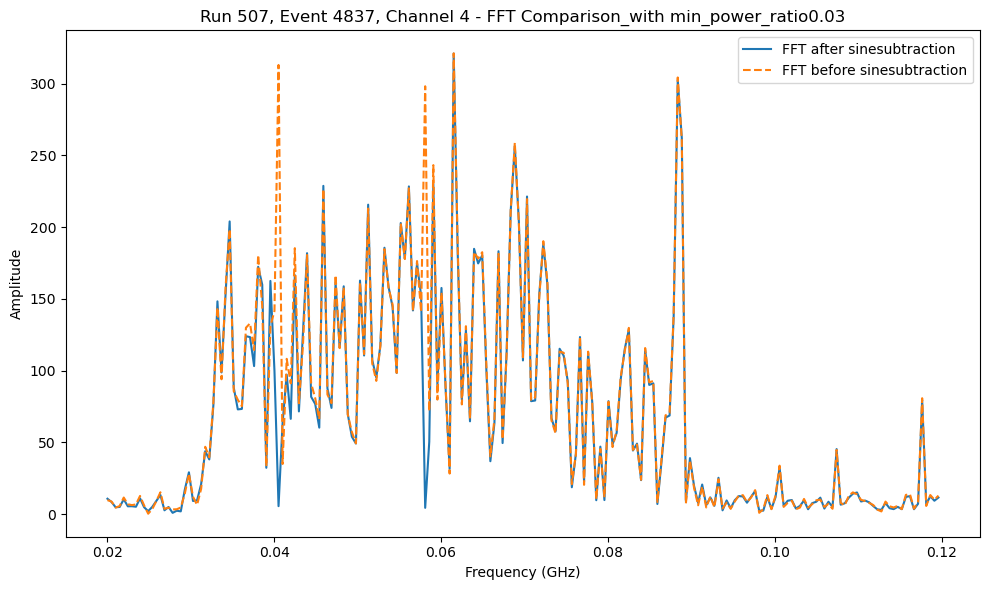

4.0407772593122475
4.0407772593122475
warning, the V_rms change is lower than 5%
nfit found: 0


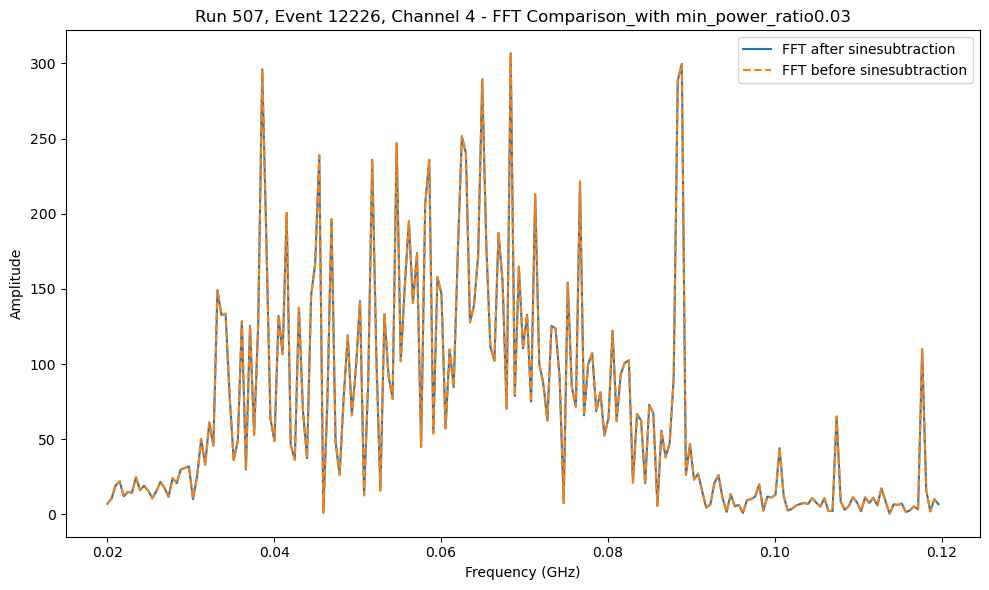

4.0983762735788405
2.5152454340219403
warning, the V_rms change is lower than 5%
nfit found: 22


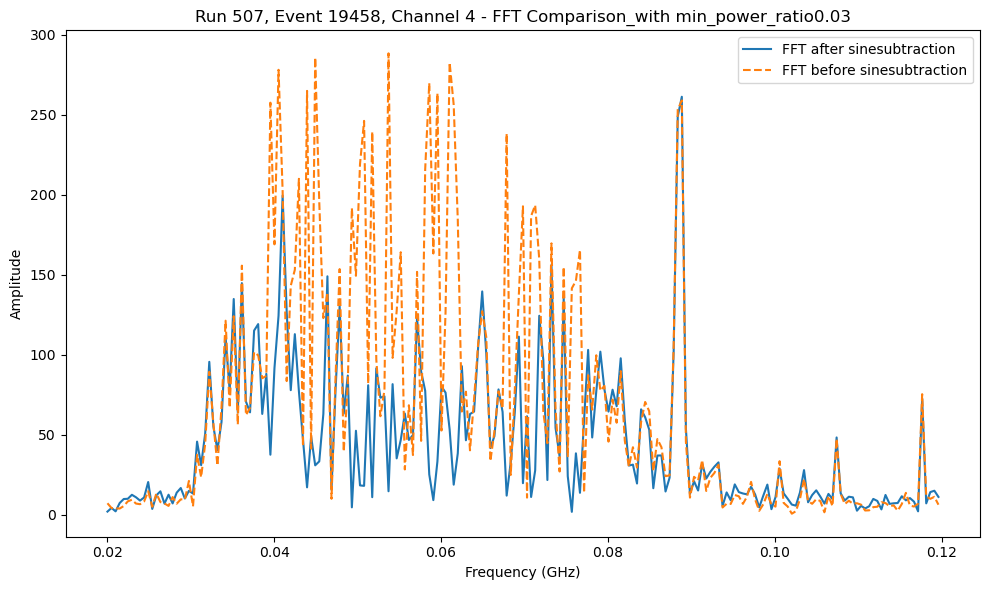

4.116938719209288
3.5861566325437395
warning, the V_rms change is lower than 5%
nfit found: 6


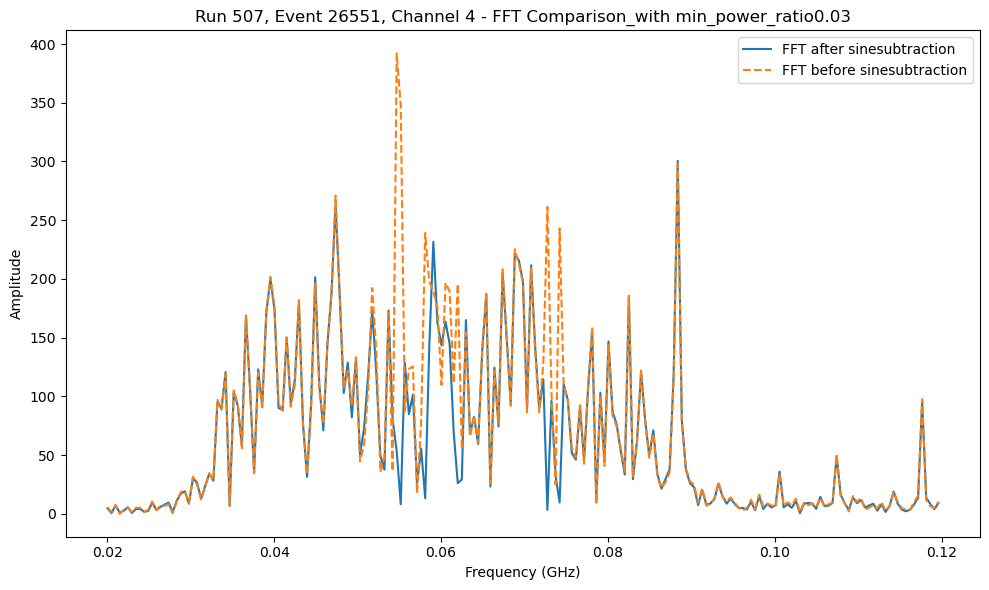

4.106833945083515
3.8582934718646107
warning, the V_rms change is lower than 5%
nfit found: 2


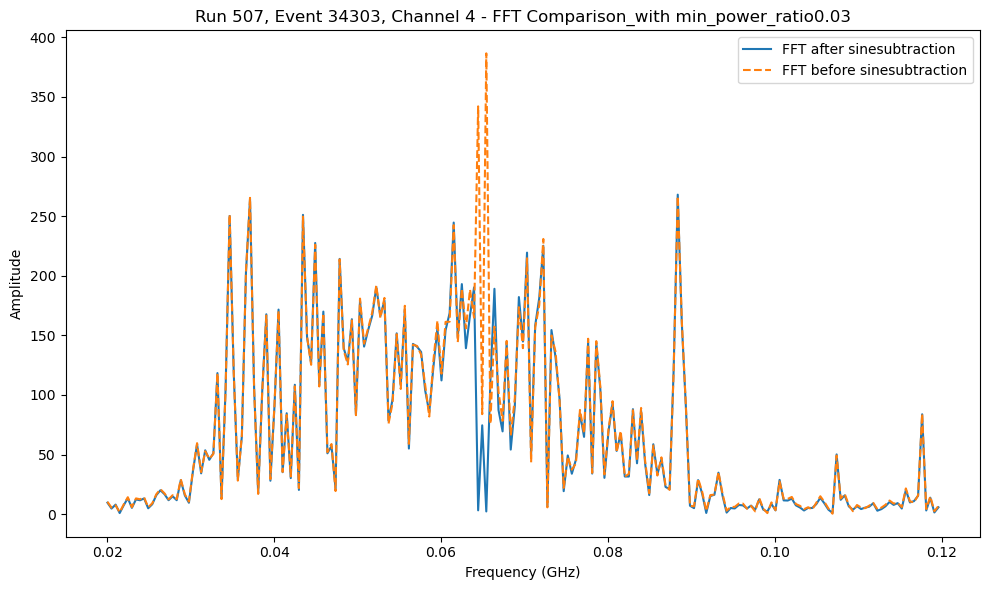

4.149060908313885
3.799164232627447
warning, the V_rms change is lower than 5%
nfit found: 4


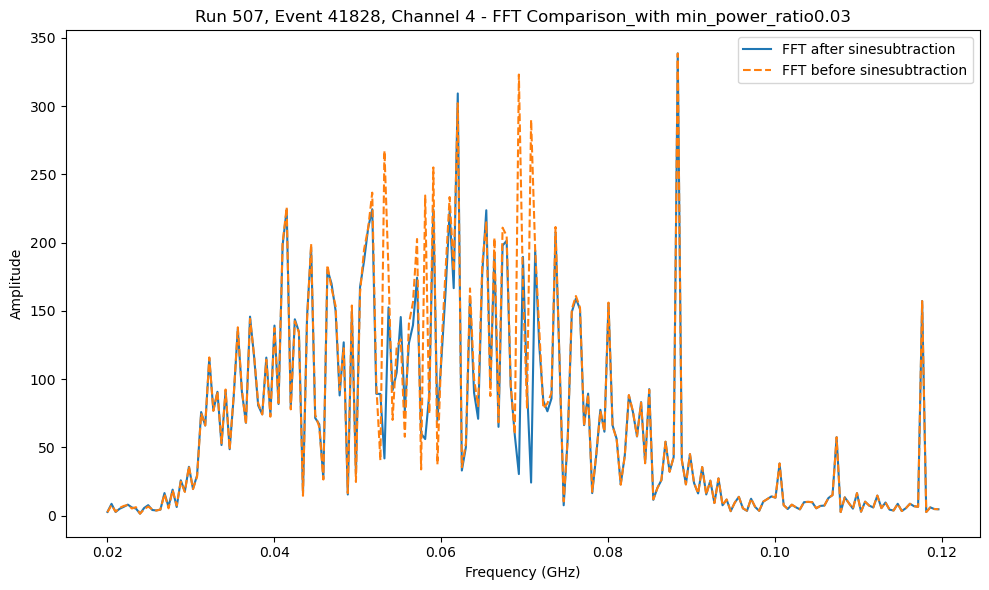

4.133506557977591
3.585642854415174
warning, the V_rms change is lower than 5%
nfit found: 6


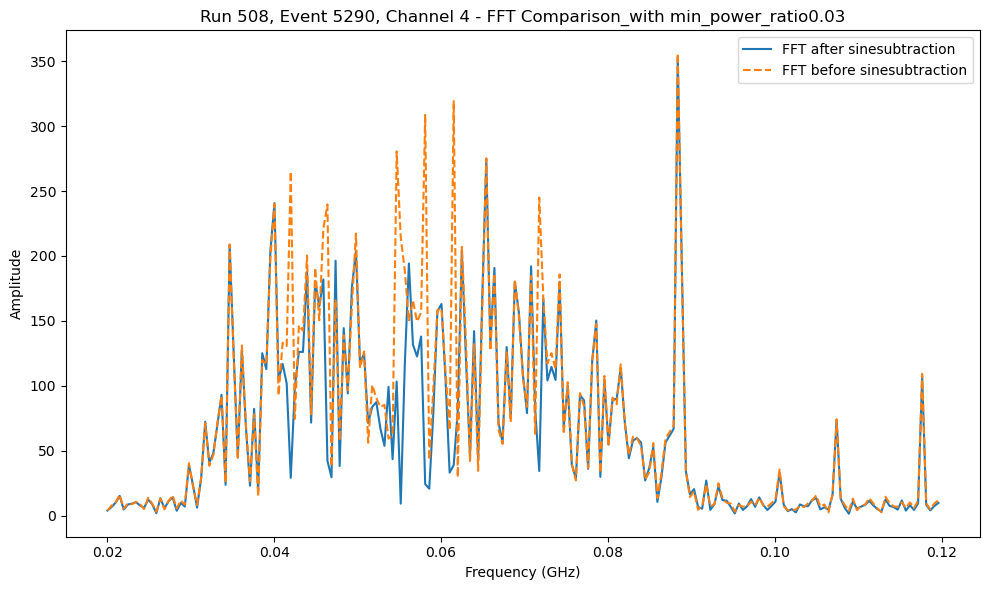

4.137292290858841
4.017598945076147
warning, the V_rms change is lower than 5%
nfit found: 1


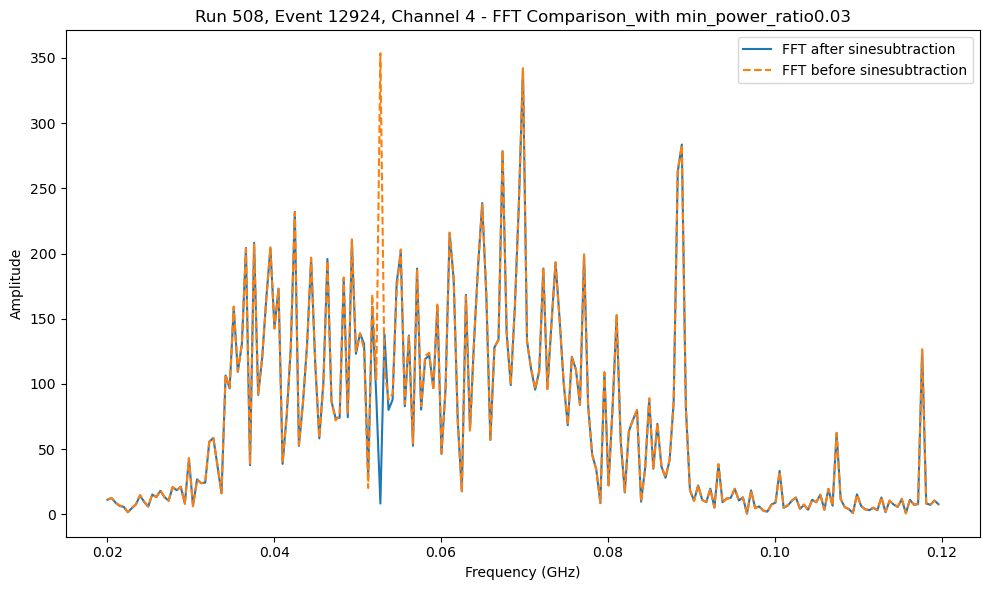

4.133395811859784
3.5115915680741097
warning, the V_rms change is lower than 5%
nfit found: 7


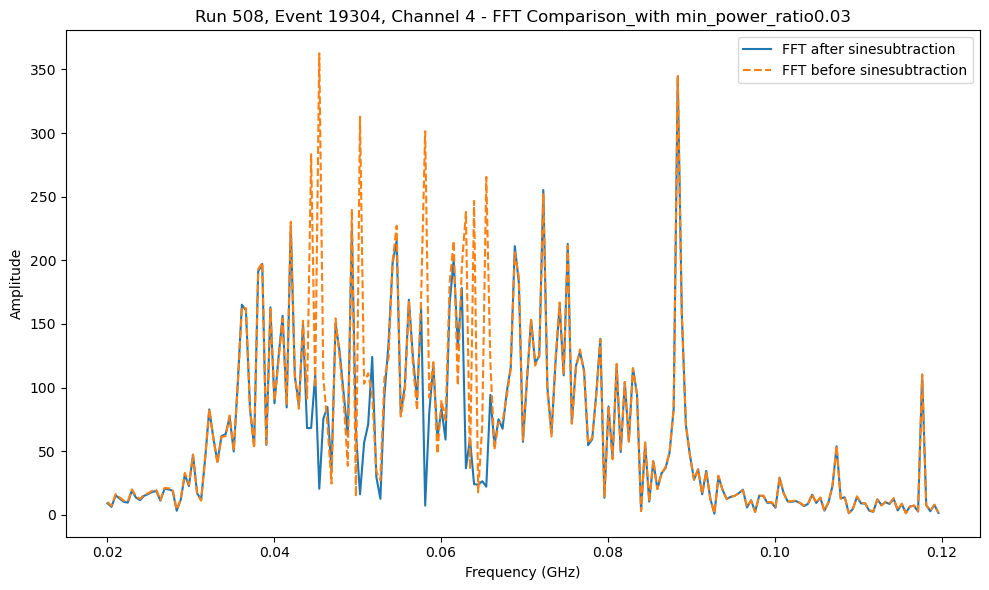

4.358443840964772
3.5104406200179077
warning, the V_rms change is lower than 5%
nfit found: 9


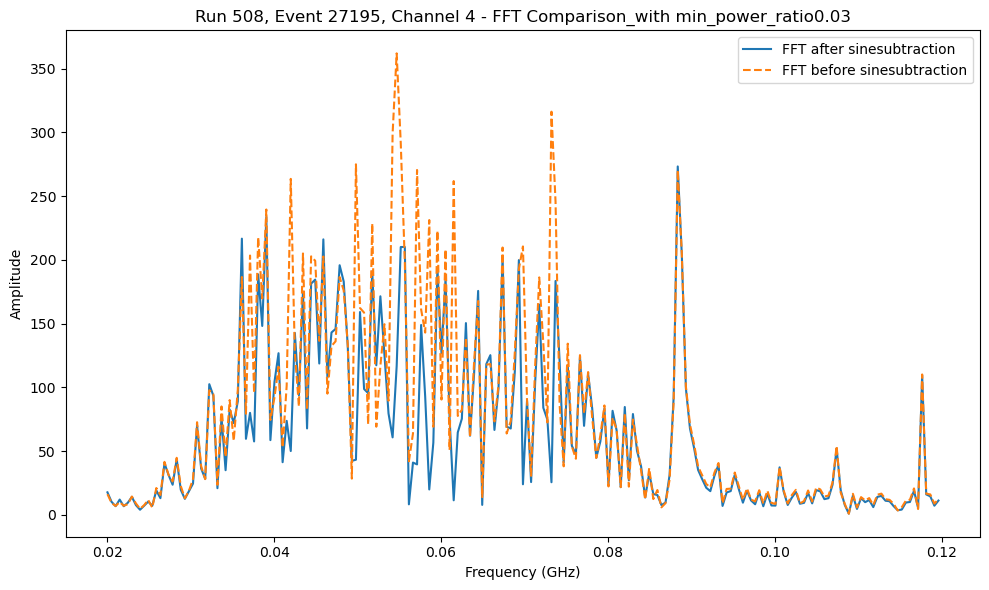

4.181431714772194
3.63813917462075
warning, the V_rms change is lower than 5%
nfit found: 5


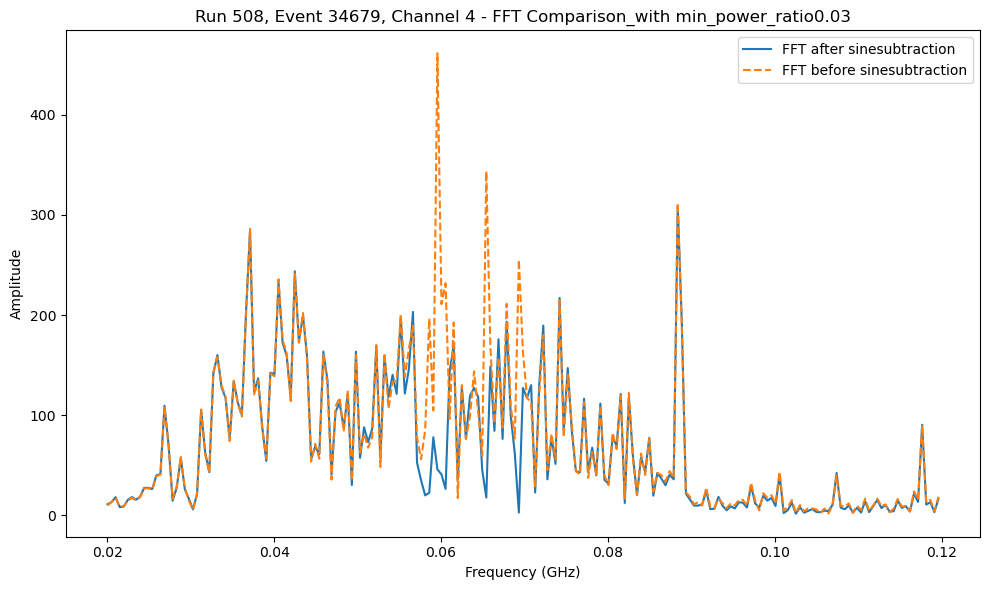

4.416763208641702
3.841888706305774
warning, the V_rms change is lower than 5%
nfit found: 5


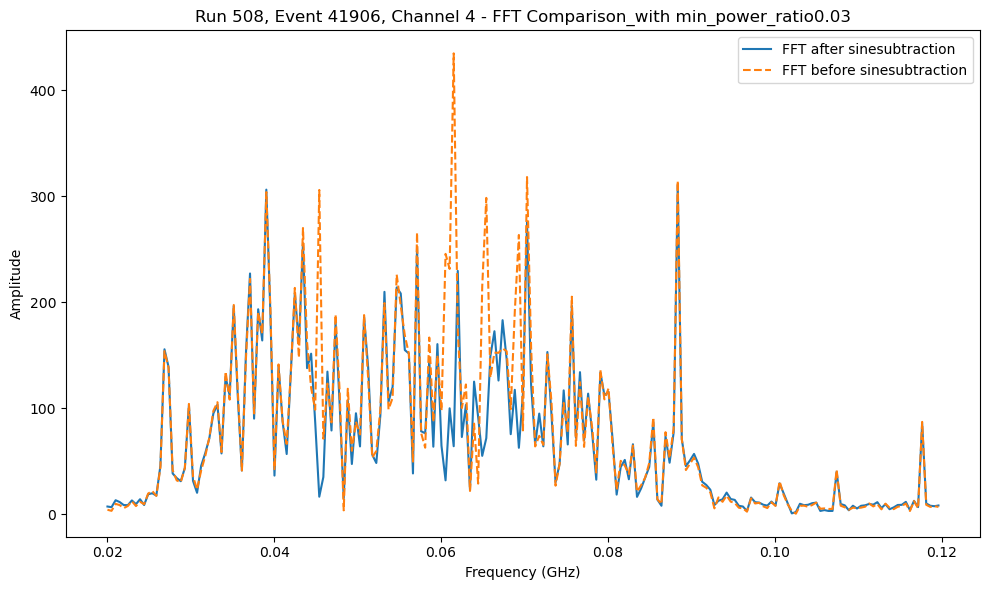

4.506896773864855
3.9484911939495566
warning, the V_rms change is lower than 5%
nfit found: 7


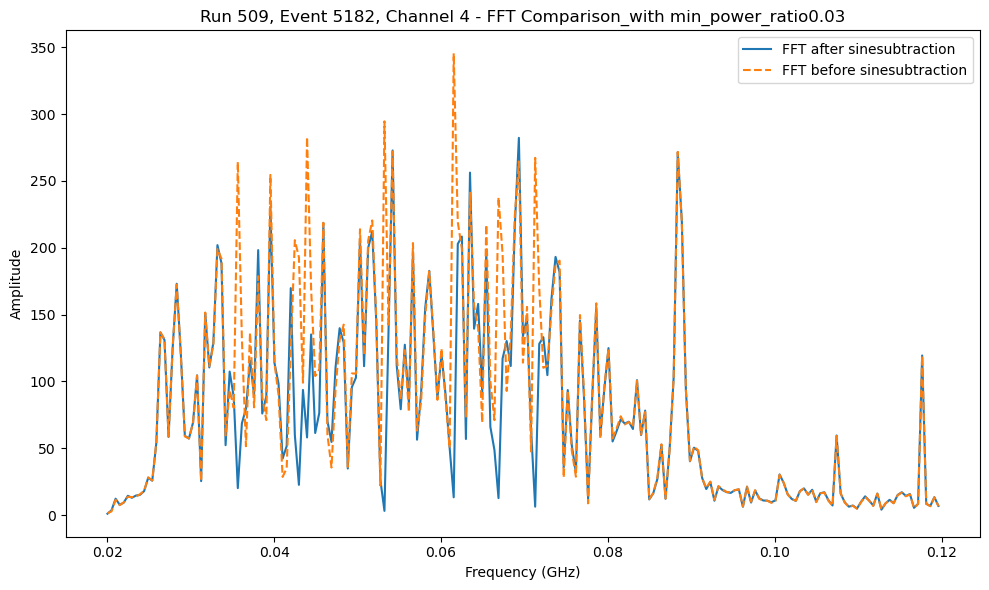

4.465576325372192
4.314994524250056
warning, the V_rms change is lower than 5%
nfit found: 2


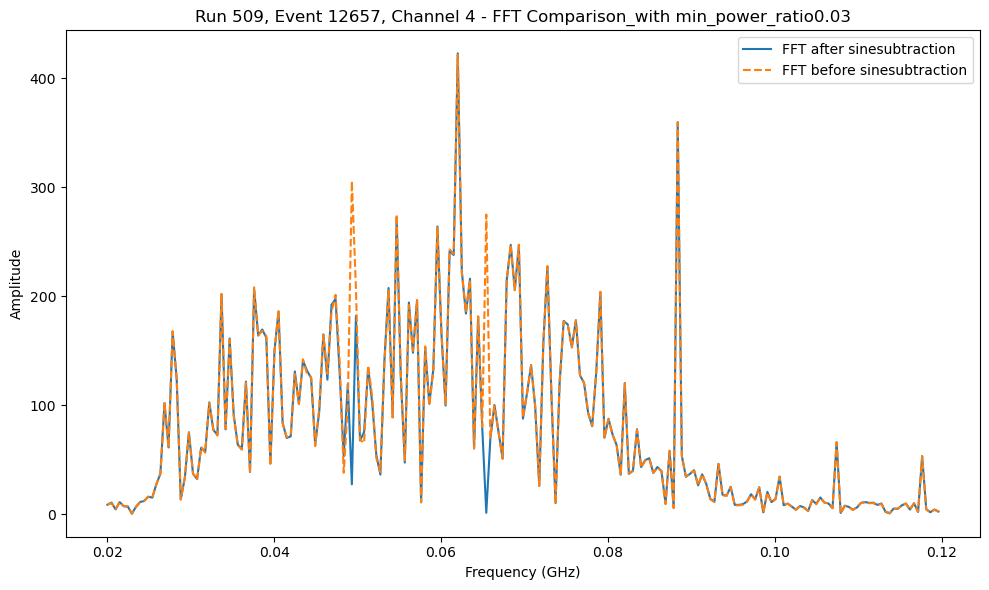

4.61273670778018
4.028791474839969
warning, the V_rms change is lower than 5%
nfit found: 5


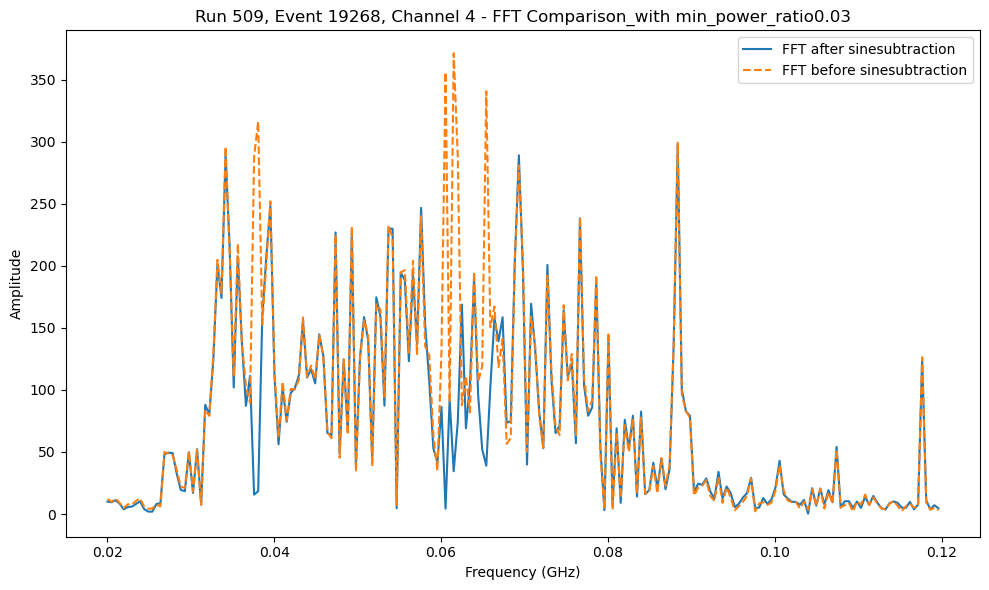

4.718226119511839
4.147701961079832
warning, the V_rms change is lower than 5%
nfit found: 3


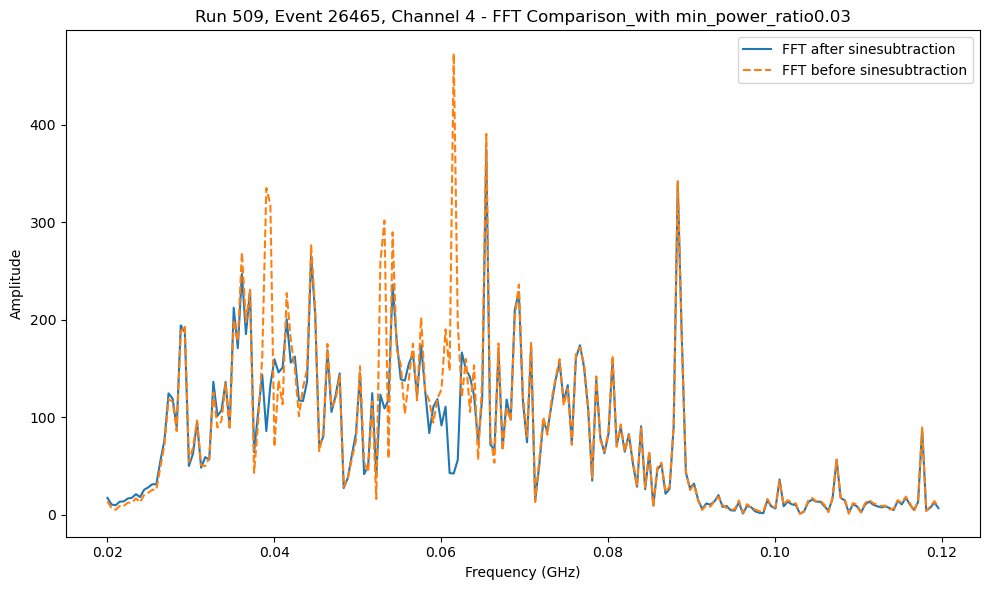

4.835971813665622
3.1541000108392665
warning, the V_rms change is lower than 5%
nfit found: 12


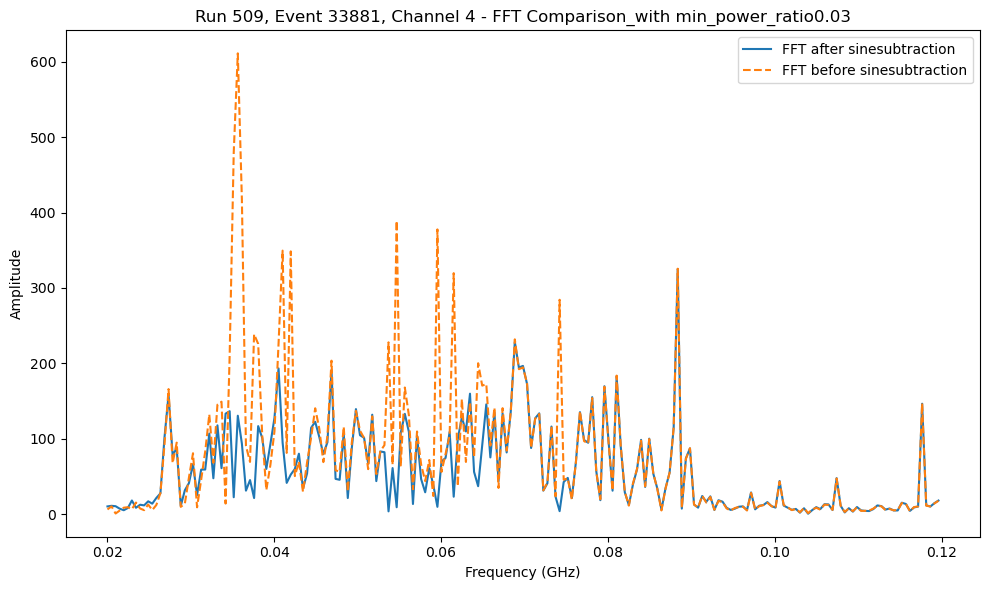

exception
7.60261827842882
4.050931522058298
warning, the V_rms change is lower than 5%
nfit found: 12


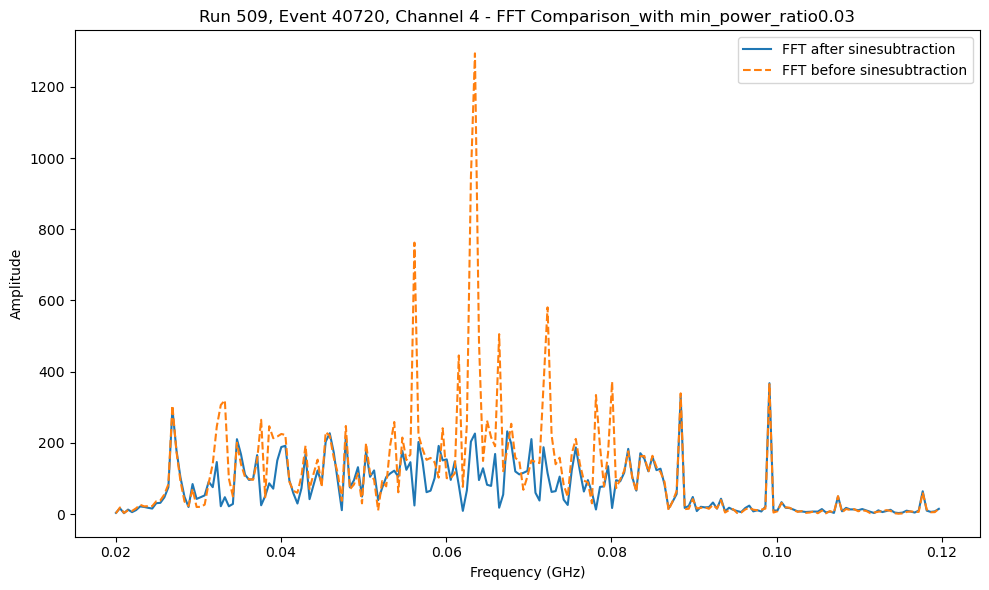

exception
8.450680532646098
5.071174667464996
warning, the V_rms change is lower than 5%
nfit found: 6


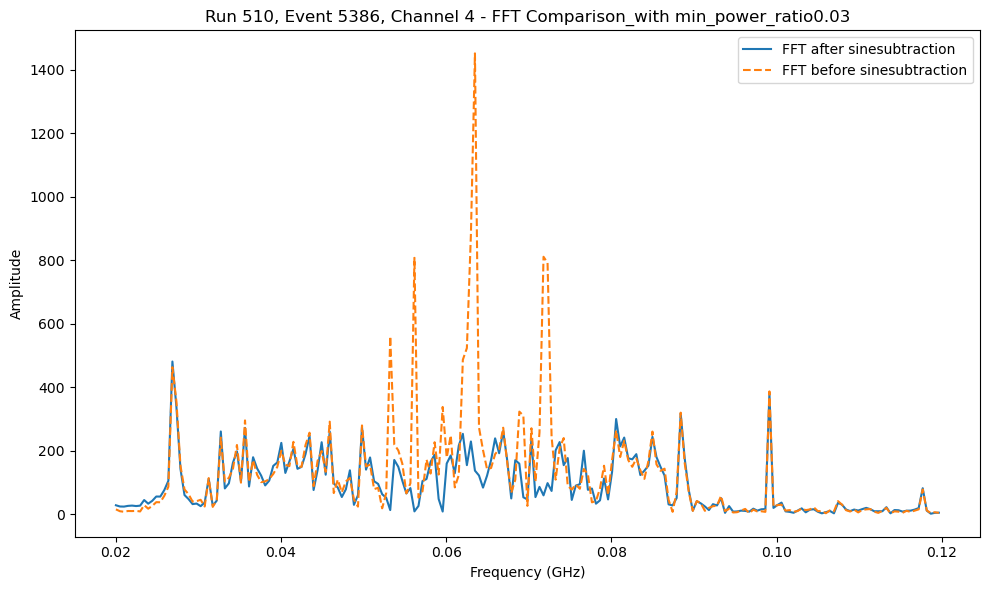

exception
8.406870539000913
8.406870539000913
warning, the V_rms change is lower than 5%
nfit found: 0


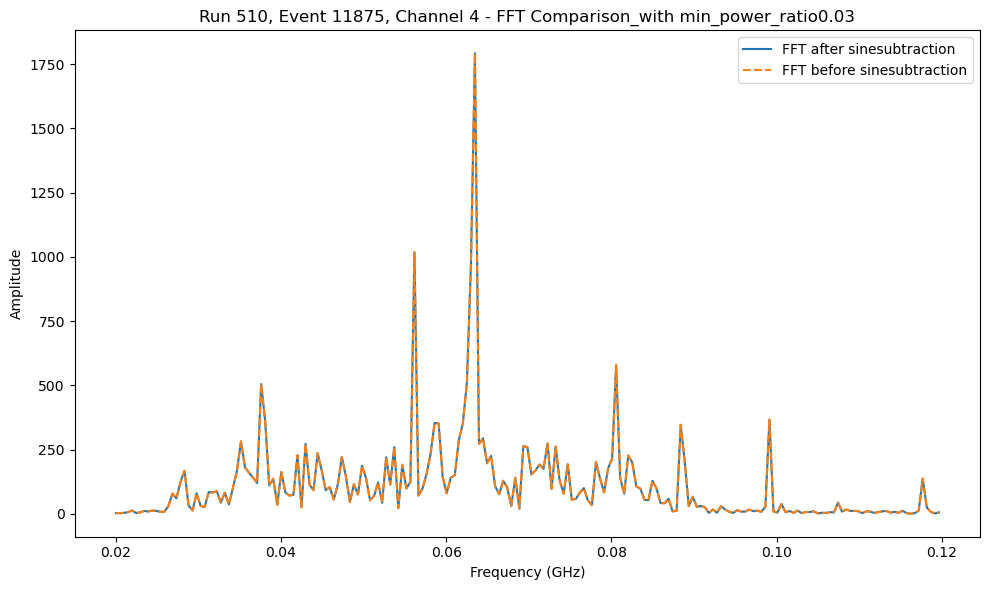

exception
8.414983700732506
8.414983700732506
warning, the V_rms change is lower than 5%
nfit found: 0


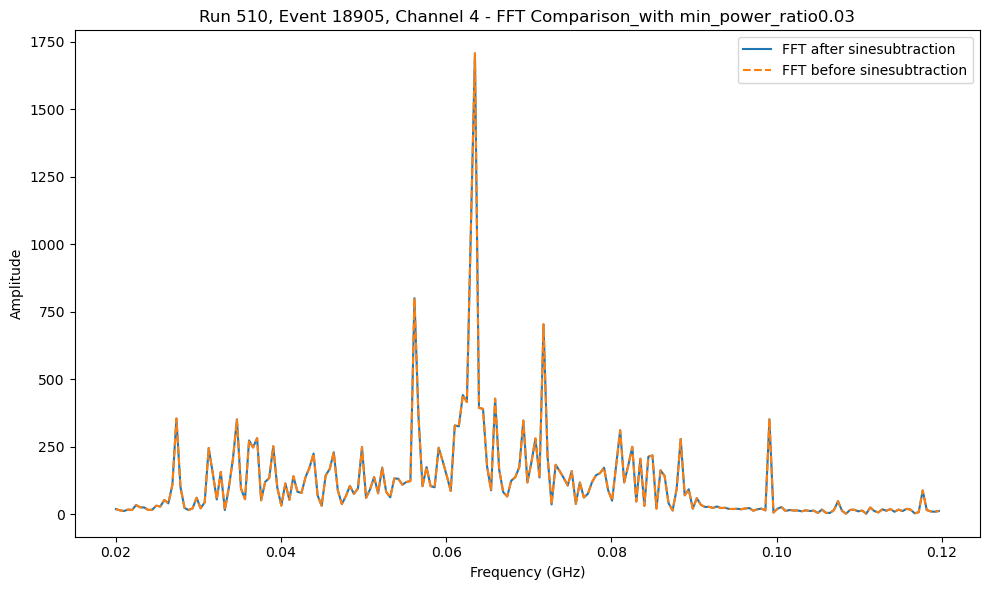

exception
8.348600085198019
5.970285634093511
warning, the V_rms change is lower than 5%
nfit found: 1


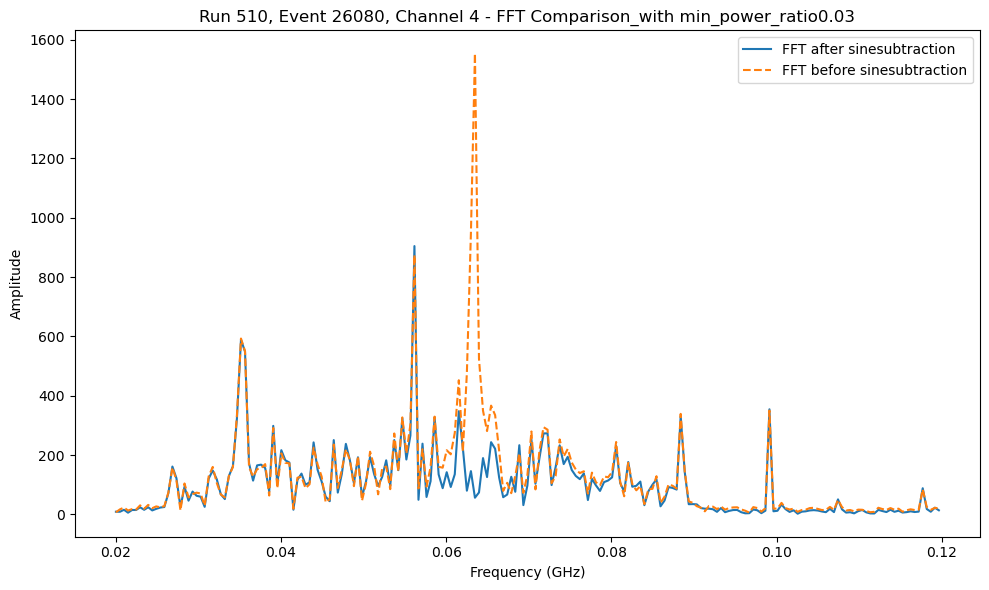

exception
8.381759420981428
3.36924551542959
warning, the V_rms change is lower than 5%
nfit found: 21


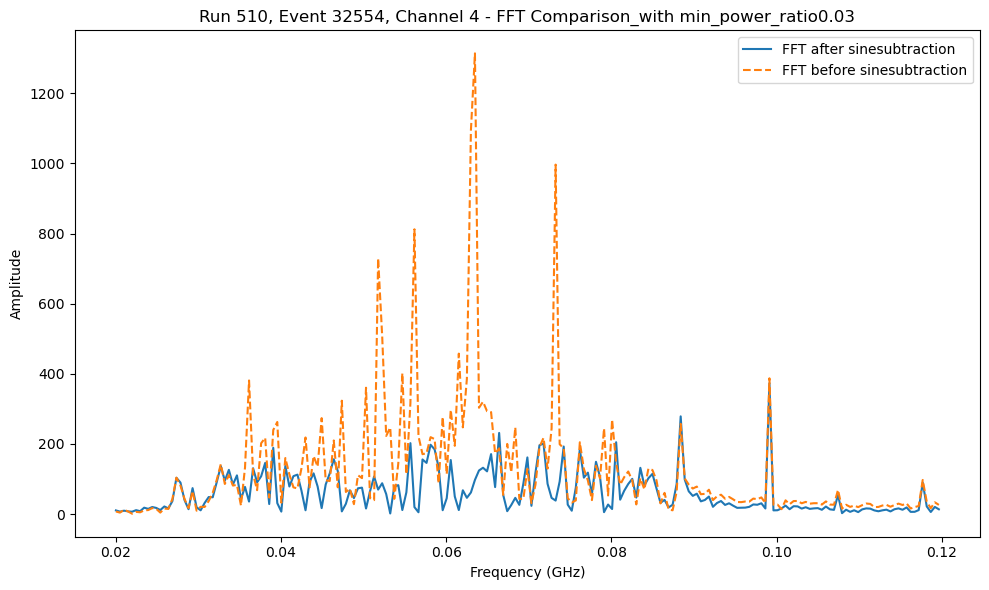

exception
7.9558275948204065
7.9558275948204065
warning, the V_rms change is lower than 5%
nfit found: 0


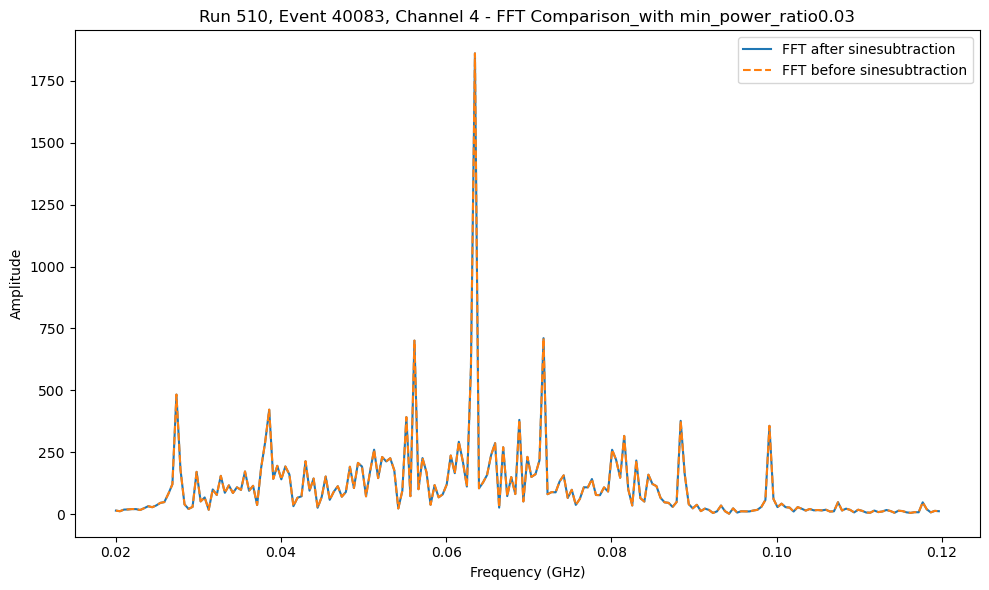

exception
7.933373527531888
7.50201010000102
warning, the V_rms change is lower than 5%
nfit found: 2


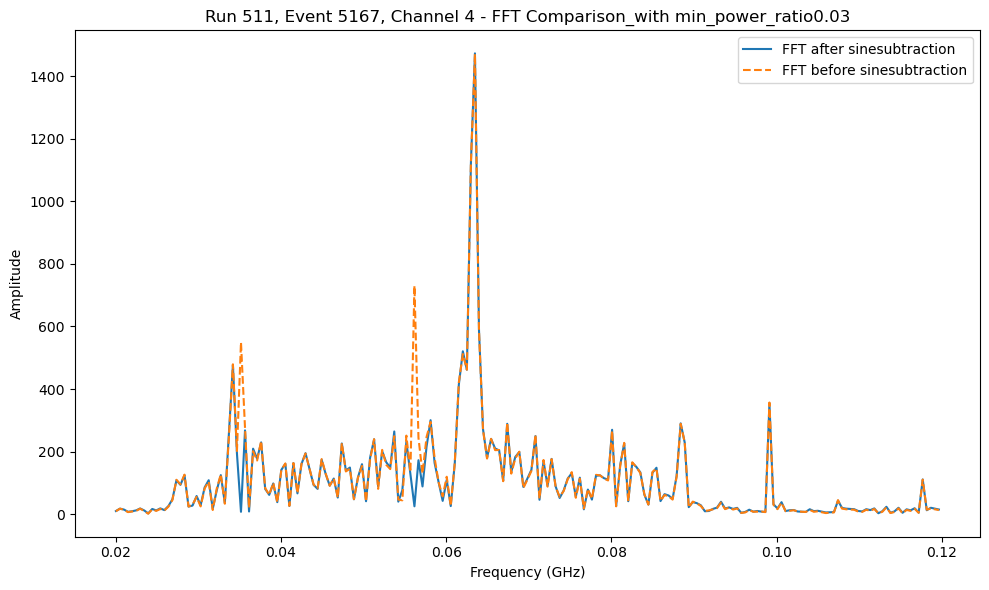

exception
8.272928454594766
4.089086701691702
warning, the V_rms change is lower than 5%
nfit found: 11


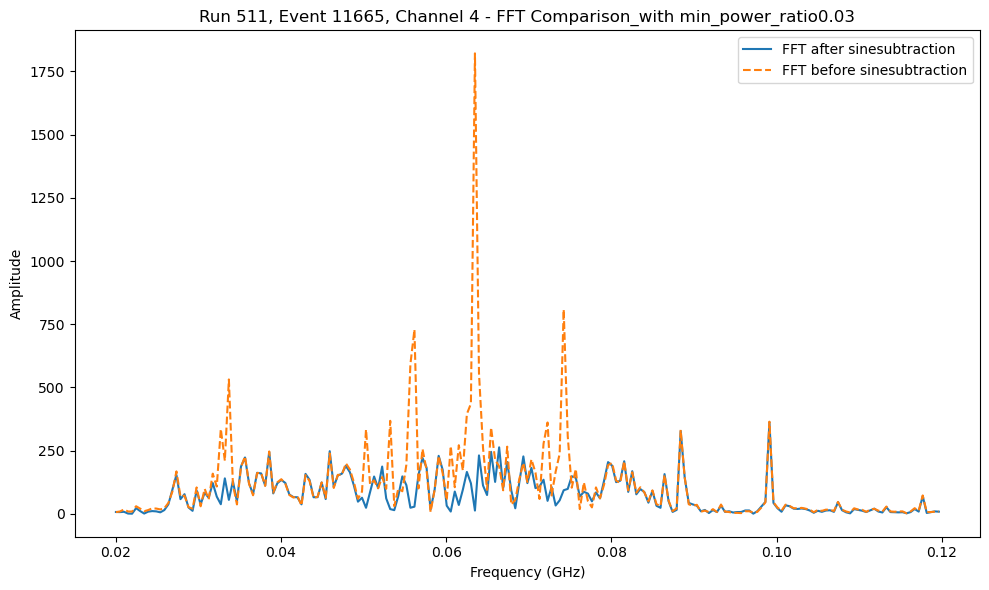

exception
8.328622427393737
4.399360585867994
warning, the V_rms change is lower than 5%
nfit found: 8


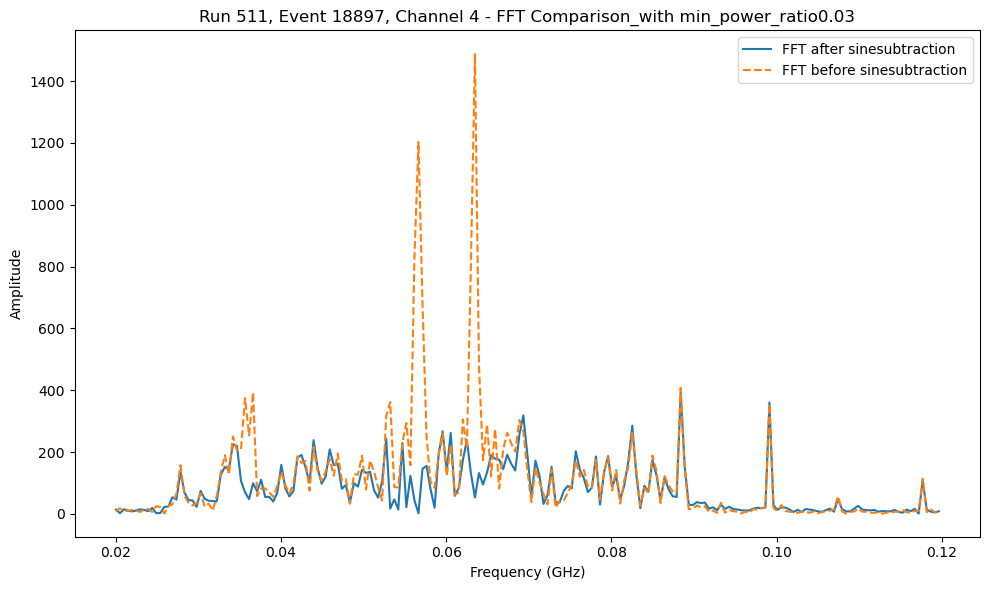

exception
8.013654262105918
4.162874298126883
warning, the V_rms change is lower than 5%
nfit found: 8


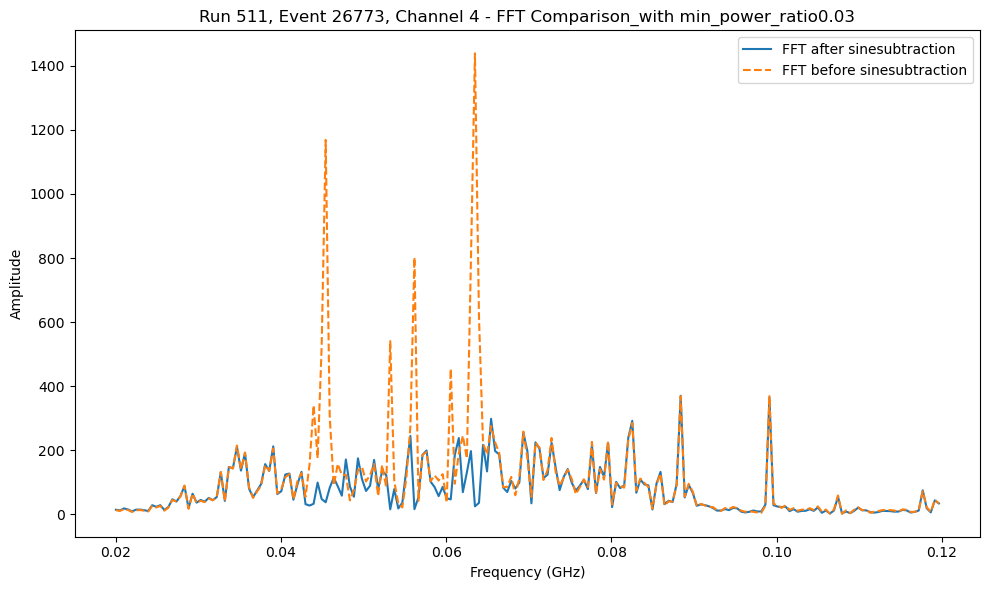

exception
8.878735038425708
4.201274351371745
warning, the V_rms change is lower than 5%
nfit found: 13


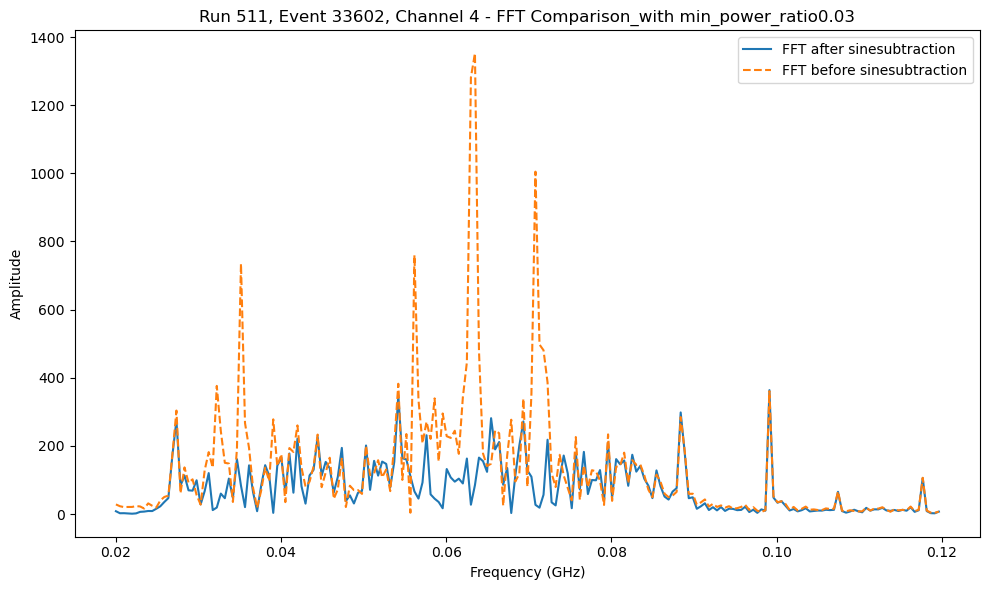

exception
8.723281393784479
5.285219678241889
warning, the V_rms change is lower than 5%
nfit found: 4


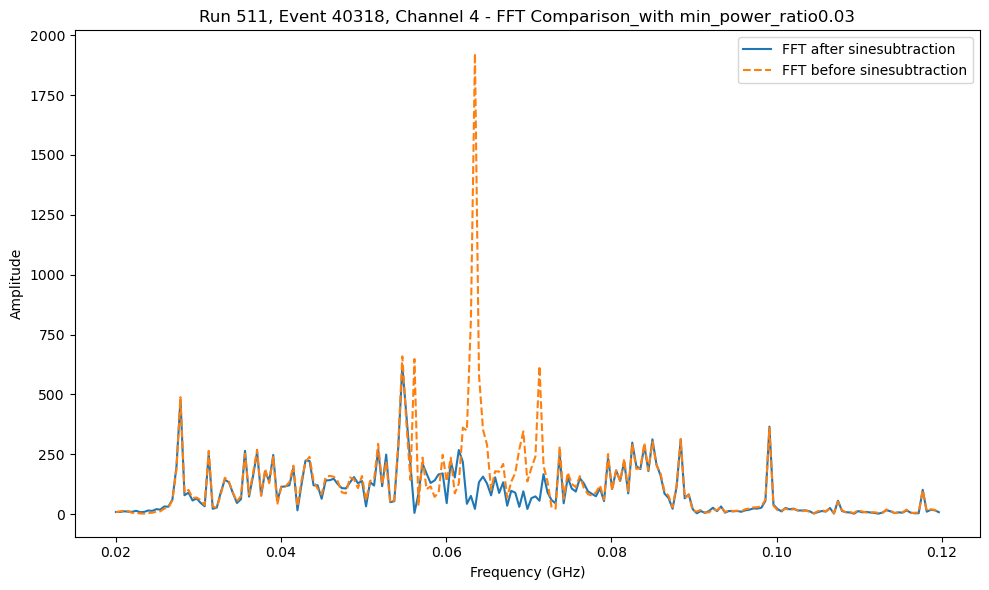

exception
7.896053207140894
5.235970922023086
warning, the V_rms change is lower than 5%
nfit found: 2


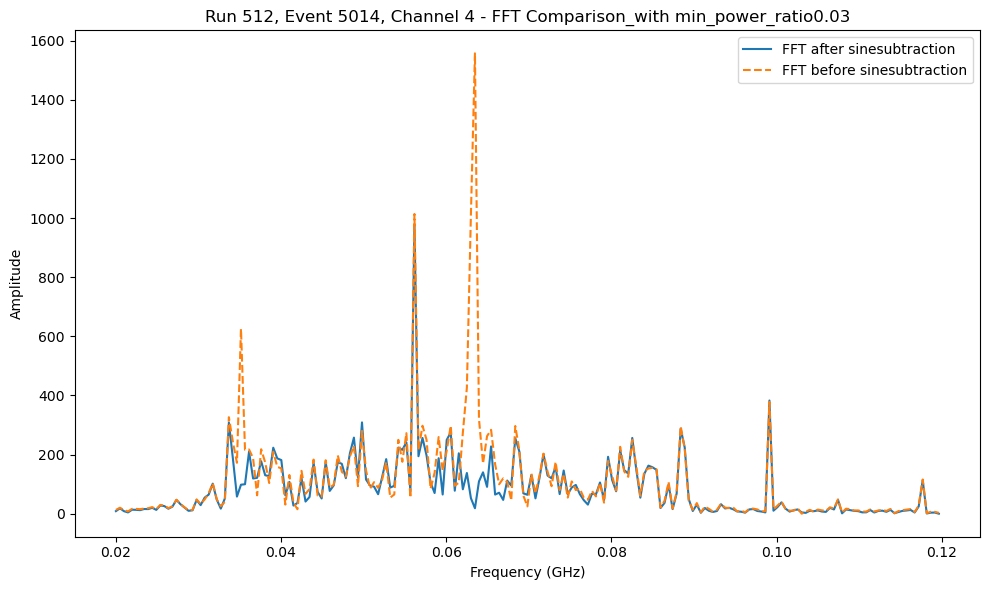

exception
8.511463065156395
8.511463065156395
warning, the V_rms change is lower than 5%
nfit found: 0


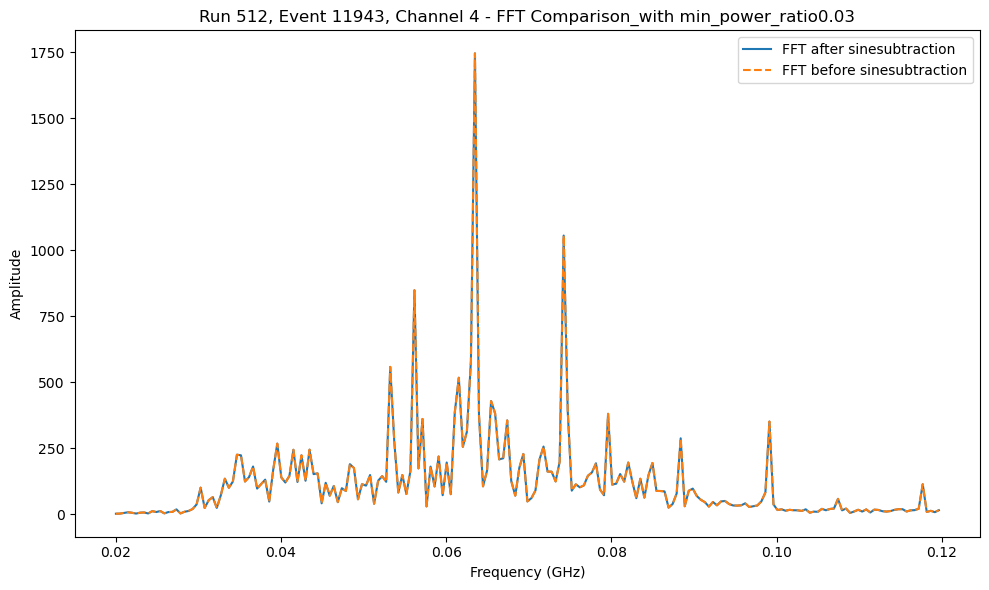

exception
8.888414158329933
6.066785773867298
warning, the V_rms change is lower than 5%
nfit found: 2


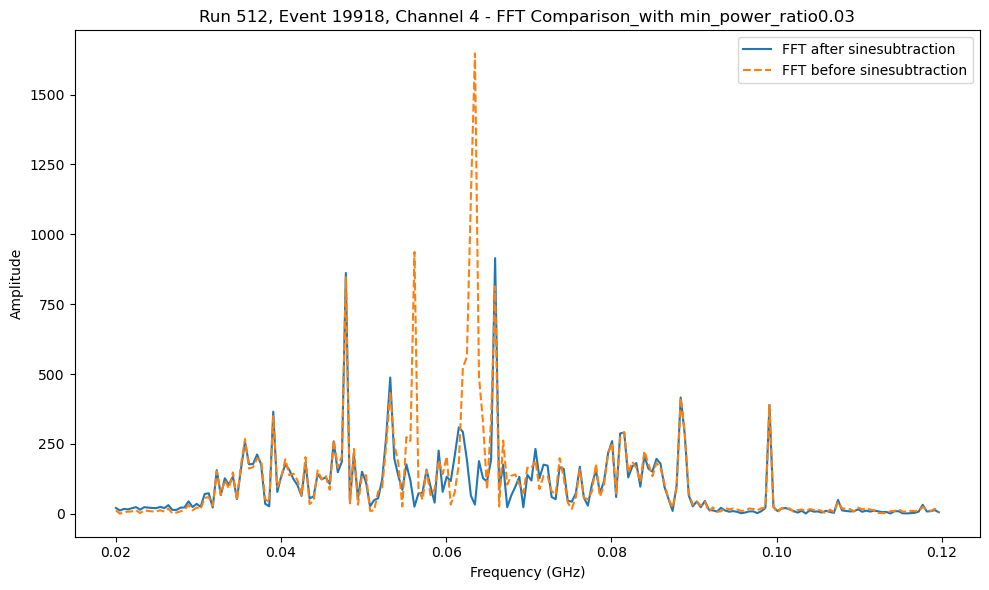

9.392033476098884
4.644267643966702
warning, the V_rms change is lower than 5%
nfit found: 5


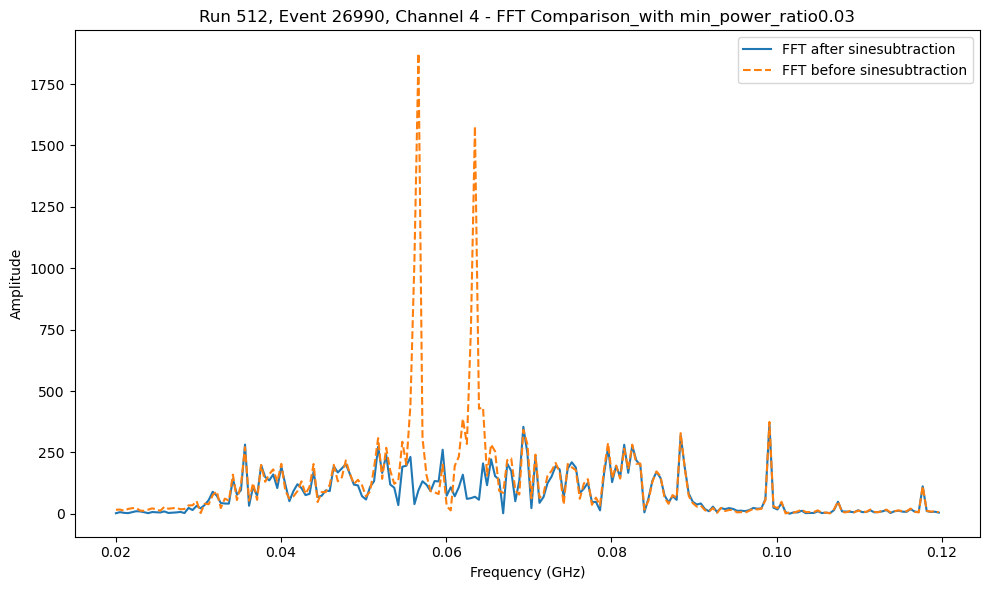

exception
8.216238588191432
4.125762995764959
warning, the V_rms change is lower than 5%
nfit found: 8


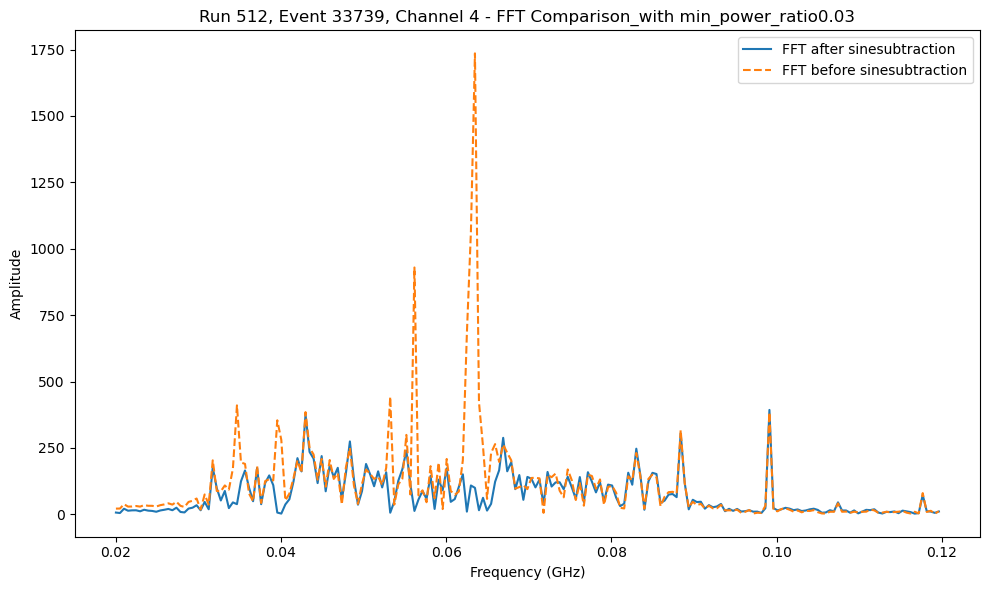

exception
8.034349845214779
4.886784541983377
warning, the V_rms change is lower than 5%
nfit found: 4


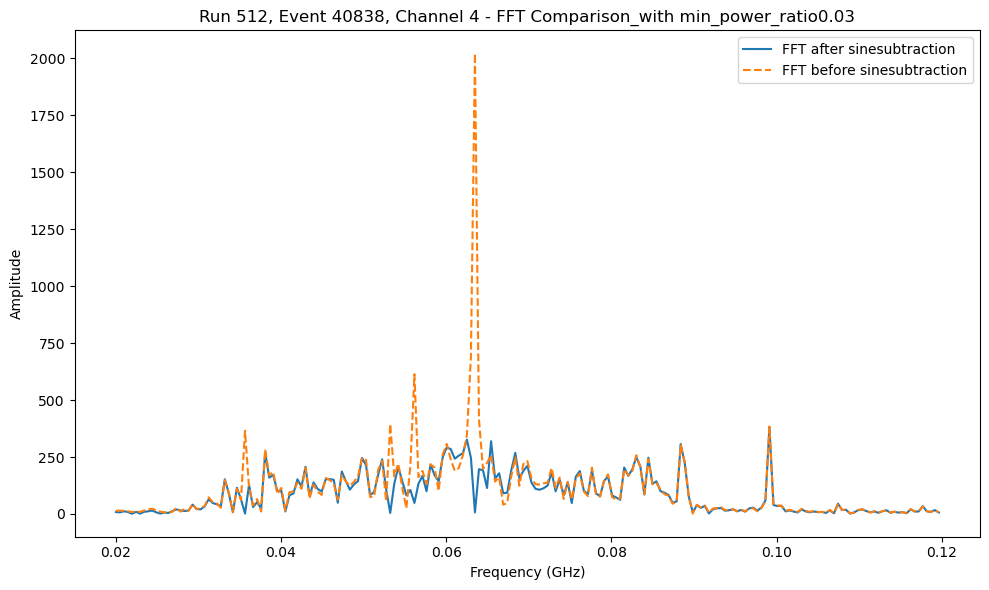

exception
8.134369363097715
4.259772315836636
warning, the V_rms change is lower than 5%
nfit found: 7


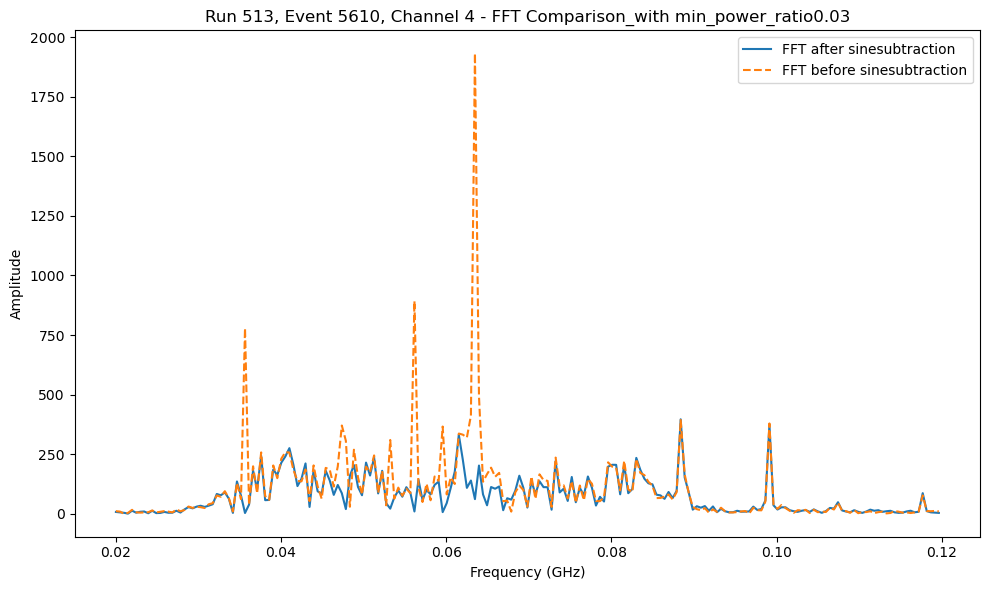

exception
8.196764647322366
4.401344436525015
warning, the V_rms change is lower than 5%
nfit found: 5


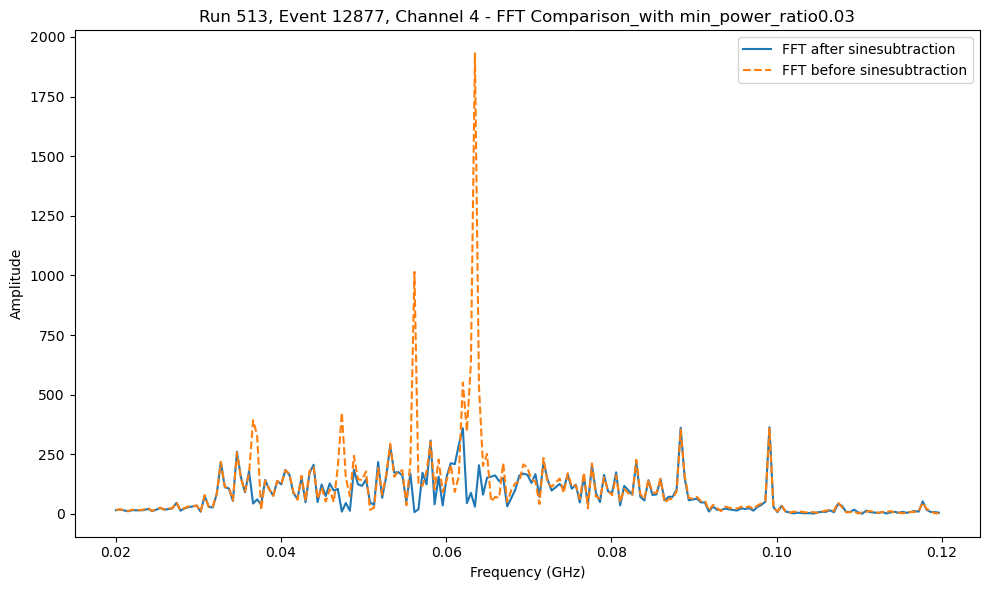

exception
8.109600556457927
8.109600556457927
warning, the V_rms change is lower than 5%
nfit found: 0


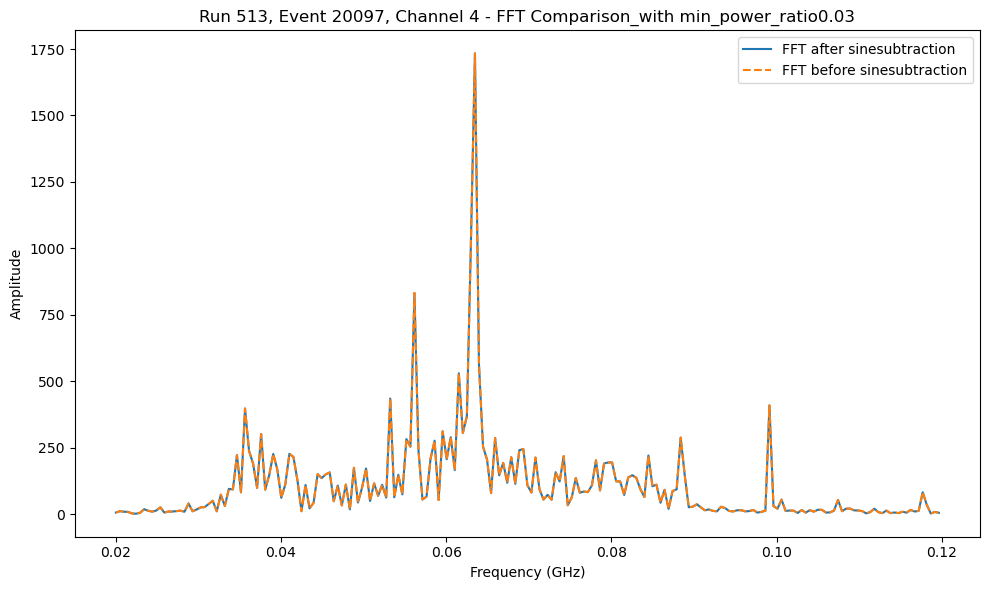

exception
8.174305774947726
3.6951646735094292
warning, the V_rms change is lower than 5%
nfit found: 8


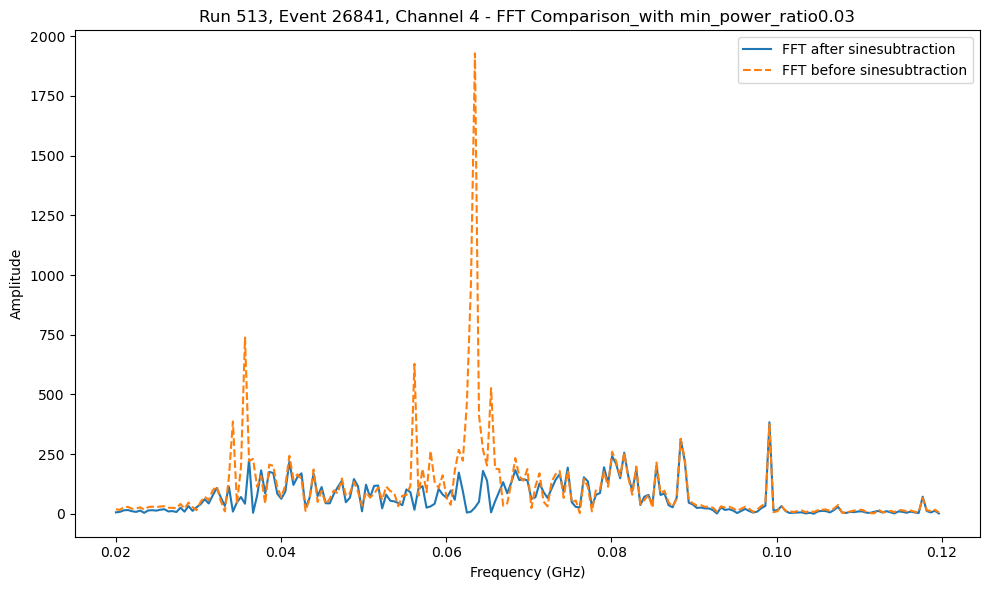

exception
8.099426164433826
8.099426164433826
warning, the V_rms change is lower than 5%
nfit found: 0


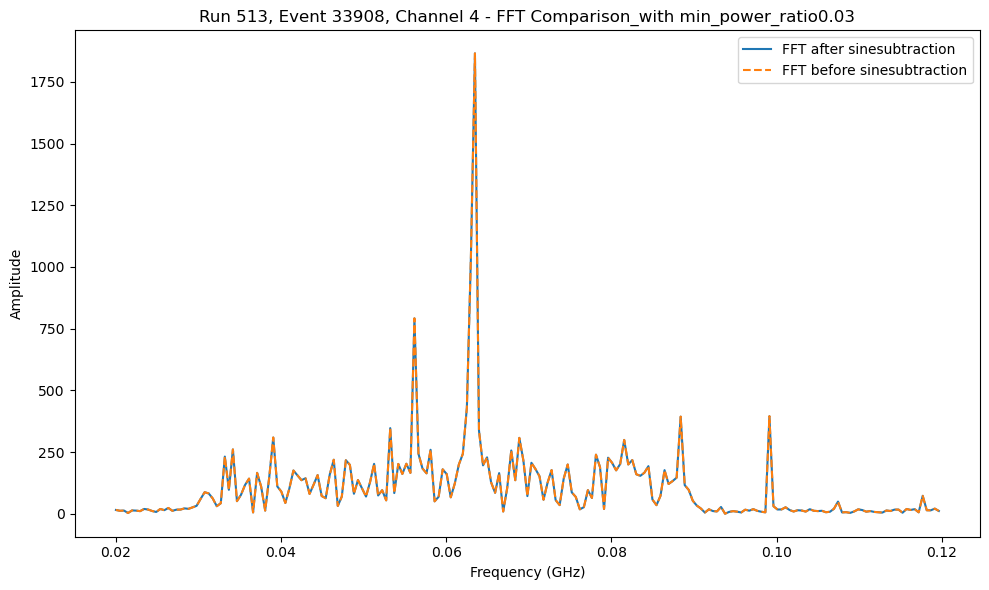

exception
8.012536478182735
8.012536478182735
warning, the V_rms change is lower than 5%
nfit found: 0


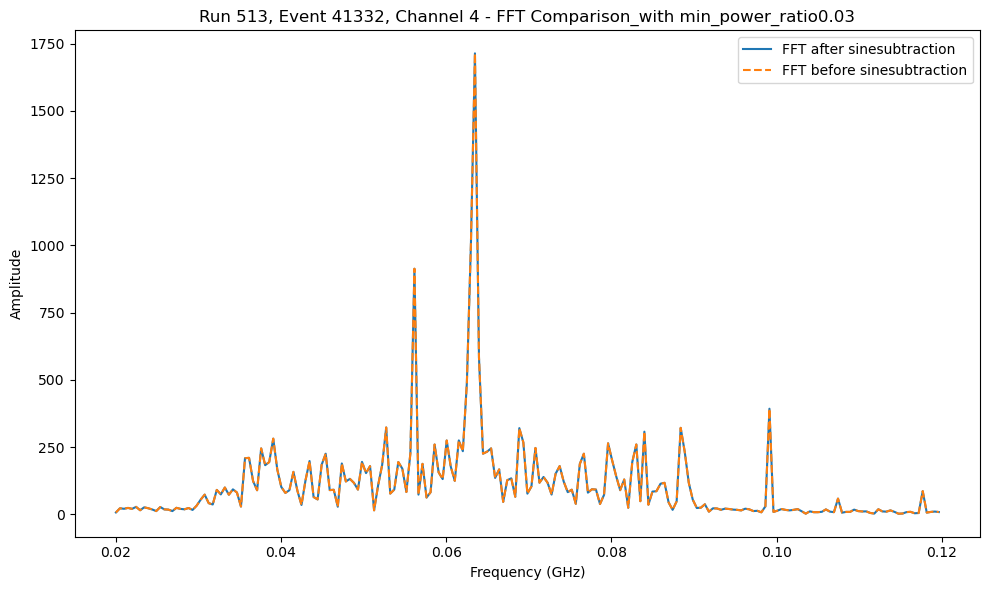

[]

max_freq (ntries: 0 nattempts: 1): 130 0.0634766
Guesses: f= 0.063477, A=22.575237, ph=(0.58670022)Guess power is 314.132425. Gradient is (-805652.935066,-127.410336,22.575237)
Minuit2Minimizer: Minimize with max-calls 545 convergence for edm < 0.01 strategy 1
Minuit2Minimizer : Valid minimum - status = 0
FVAL  = 31.5676341486302796
Edm   = 1.53444677716461052e-06
Nfcn  = 85
f	  = 0.0632832	 +/-  4.95348e-05	(limited)
phi0	  = 3.37303	 +/-  0.368844
A0	  = 7.45335	 +/-  1.41175	(limited)
Minuit2Minimizer : Valid minimum - status = 0
FVAL  = 31.5676341486302796
Edm   = 1.53444677716461052e-06
Nfcn  = 85
f	  = 0.0632832	 +/-  4.95348e-05	(limited)
phi0	  = 3.37303	 +/-  0.368844
A0	  = 7.45335	 +/-  1.41175	(limited)
Power Ratio: 0.467768
max_freq (ntries: 0 nattempts: 2): 115 0.0561523
Guesses: f= 0.056152, A=13.322665, ph=(-3.0779296)Guess power is 120.314342. Gradient is (-273795.312149,-44.373354,13.322665)
Minuit2Minimizer: Minimize with max-calls 545 convergence for edm < 0.01 stra

Warning in <Minuit2>: MnHesse Analytical calculator  	[   -0.01087388459  -0.004460575711   0.004451050664]	  numerical  	[   -0.01086373724  -0.004460571275   0.004476743526]	  g2  	[      65.92359875      55.60834599      149.7720724]	
Warning in <Minuit2>: MnHesse Analytical calculator  	[   -0.01133429297   0.004263231244    0.02099466755]	  numerical  	[   -0.01133350506   0.004263234995    0.02104222954]	  g2  	[      36.31042564      11.30554566      2.318198218]	
Warning in <Minuit2>: MnHesse Analytical calculator  	[    0.00256367466  -0.000915034626   0.001261407809]	  numerical  	[   0.002564439166 -0.0009150299747   0.001401735751]	  g2  	[      36.17801266      11.25871497      1.276481282]	
Warning in <Minuit2>: VariableMetricBuilder No improvement in line search
Warning in <Minuit2>: VariableMetricBuilder Iterations finish without convergence; Edm 5.19429e+08 Requested 2e-05
Warning in <Minuit2>: MnHesse Analytical calculator  	[     -1.728311785    -0.5143177938        

In [6]:
#n=0
power_ratio=0.03
outlier_printer=True
max_freq_arr=[]

waveform_txt=[]
run_txt=[]
entry_txt=[]
frequency_txt=[]

for event in medium_events:
    #n=n+1
    vrms_median_arr.append(event.V_rms)
    t_array.append(event.readout_time)
    event_sample=event
    nfit,y,max_freq_discard=event.sine_subtraction(False,0.03,0.08,power_ratio)
    nfit,y,max_freq=event.sine_subtraction(True,0.06,0.065,0.05)
    # if nfit==0:
    #     waveform_txt.append(event.waveform)
    #     run_txt.append(event.run)
    #     entry_txt.append(event.entry)
    #     frequency_txt.append(max_freq_discard)
    vrms_median_arr_capped.append(event.V_rms)
    max_freq_arr.append(max_freq)
[print(a,b) for (a,b) in zip(vrms_median_arr_capped, max_freq_arr)]


In [7]:
#print the data for Alisa

# # Create a directory to store the output files if it doesn't exist
# output_dir = "Questioned_waveform_outputs"
# os.makedirs(output_dir, exist_ok=True)

# # Iterate through all waveform data and save to separate files
# for i, waveform in enumerate(waveform_txt):
#     run = run_txt[i]
#     entry = entry_txt[i]
#     frequency = frequency_txt[i]
    
#     # Define the filename and the content
#     filename = os.path.join(output_dir, f"waveform_run{run}_entry{entry}.txt")
#     content = (
#         f"Title: Waveform Data for Run {run}, Entry {entry}\n"
#         f"Frequency: {frequency} Hz\n\n"
#         "Waveform:\n"
#         + "\n".join(map(str, waveform))
#     )
    
#     # Write the content to the file
#     with open(filename, "w") as file:
#         file.write(content)

# print(f"Waveform data saved to {output_dir}.")

Waveform data saved to Questioned_waveform_outputs.


In [8]:
# n=0

# for event in medium_events:
#     n=n+1
#     vrms_median_arr.append(event.V_rms)
#     t_array.append(event.readout_time)
#     if n<10:
#         event.plot_amplitude()
#     event.cap_amplitude_value(10)
#     #event.cap_amplitude_proportion(0.2)
#     vrms_median_arr_capped.append(event.V_rms)

ValueError: x and y must have same first dimension, but have shapes (49,) and (0,)

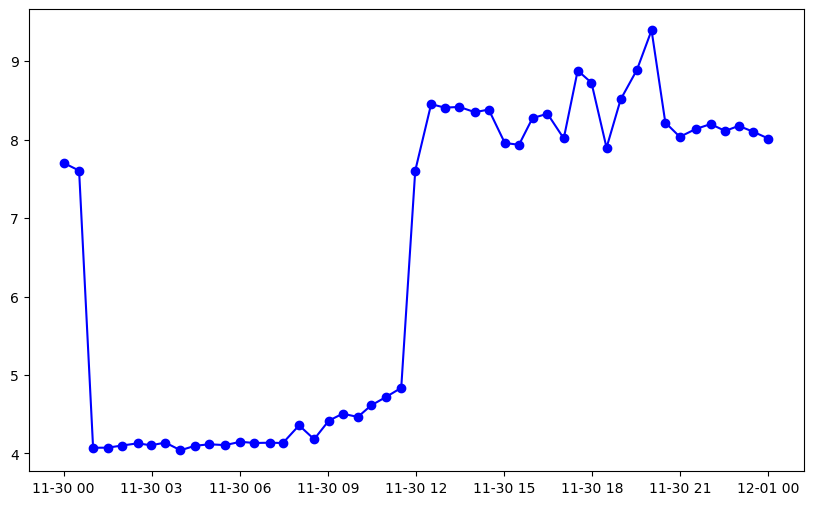

In [9]:
# Convert t_array (timestamps) to datetime objects
t_array_datetime = [datetime.fromtimestamp(t) for t in t_array]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the original V_rms values
plt.plot(t_array_datetime, vrms_median_arr, label='V_rms (Original)', marker='o', linestyle='-', color='b')

# Plot the capped V_rms values
plt.plot(t_array_datetime, vrms_median_arr_capped, label='V_rms (Capped)', marker='x', linestyle='--', color='r')

# Add labels and title
plt.xlabel("Readout Time (HH:MM)")
plt.ylabel("V_rms")

# Title with channel and start time information
start_time_str = t_array_datetime[0].strftime('%Y-%m-%d %H:%M:%S')
plt.title(f"Comparison of V_rms Before and After Capping at 10% - Channel {channel} short band double sine subtracted for {power_ratio}")
plt.legend()

# Set x-axis major formatter to display hours and minutes only
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add grid for better readability
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the plot with channel and start time in the filename
filename = f"V_rms_Comparison_Channel_{channel}_Start_{t_array_datetime[0].strftime('%Y%m%d_%H%M')}_short_band_doublesine_subtracted_at_{power_ratio}.png"
plt.savefig(filename, dpi=300)

# Show the plot
plt.show()

In [11]:
print(medium_events[0].t)

[   0.    4.    8.   12.   16.   20.   24.   28.   32.   36.   40.   44.
   48.   52.   56.   60.   64.   68.   72.   76.   80.   84.   88.   92.
   96.  100.  104.  108.  112.  116.  120.  124.  128.  132.  136.  140.
  144.  148.  152.  156.  160.  164.  168.  172.  176.  180.  184.  188.
  192.  196.  200.  204.  208.  212.  216.  220.  224.  228.  232.  236.
  240.  244.  248.  252.  256.  260.  264.  268.  272.  276.  280.  284.
  288.  292.  296.  300.  304.  308.  312.  316.  320.  324.  328.  332.
  336.  340.  344.  348.  352.  356.  360.  364.  368.  372.  376.  380.
  384.  388.  392.  396.  400.  404.  408.  412.  416.  420.  424.  428.
  432.  436.  440.  444.  448.  452.  456.  460.  464.  468.  472.  476.
  480.  484.  488.  492.  496.  500.  504.  508.  512.  516.  520.  524.
  528.  532.  536.  540.  544.  548.  552.  556.  560.  564.  568.  572.
  576.  580.  584.  588.  592.  596.  600.  604.  608.  612.  616.  620.
  624.  628.  632.  636.  640.  644.  648.  652.  6